# Evaluation
This notebook will walk you step by step through the process of using the detection results files included in the zip folders of each pre-trained model.

In [168]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from itertools import cycle
from PIL import Image
import numpy as np
import pandas as pd
import pickle
import os
import copy

np.random.seed(1)

In [169]:
EPSILON = 1e-5
# Load GTSDB validation images
#CLASSES = ['prohibitory','mandatory','danger']
CLASSES = ['Speed limit','Pass either side','Obstruction', 'Roadway diverges', 'Bumps']
#Path to the German Traffic Sign Detection Benchmark dataset
#DATASET_PATH = '~/Datasets/GermanTSDataset/Detection'
DATASET_PATH = './mtsd_data/mtsd_test_images/'
# full_set = ['%05d.jpg' % x for x in range(900)]
# valid_set = full_set[600:900]
test_set = [f for f in os.listdir(DATASET_PATH) if f.lower().endswith('.jpg')]

print("Test set size:", len(test_set))

Test set size: 100


In [170]:
# category_index = {1: {'id': 1, 'name': 'prohibitory'},
#  2: {'id': 2, 'name': 'mandatory'},
#  3: {'id': 3, 'name': 'danger'}}
# categories = [{'id': 1, 'name': 'prohibitory'},
#  {'id': 2, 'name': 'mandatory'},
#  {'id': 3, 'name': 'danger'}]

In [171]:
category_index = {1: {'id': 1, 'name': 'Speed limit'},
 2: {'id': 2, 'name': 'Pass either side'},
 3: {'id': 3, 'name': 'Obstruction'},
 4: {'id': 4, 'name': 'Roadway diverges'},
 5: {'id': 5, 'name': 'Bumps'}}
categories = [{'id': 1, 'name': 'Speed limit'},
 {'id': 2, 'name': 'Pass either side'},
 {'id': 3, 'name': 'Obstruction'},
 {'id': 4, 'name': 'Roadway diverges'},
 {'id': 5, 'name': 'Bumps'}]

## Load detection results

In [172]:
# MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous'
# MODEL_NAME = 'faster_rcnn_resnet_101'
# MODEL_NAME = 'faster_rcnn_resnet50'
# MODEL_NAME = 'faster_rcnn_inception_v2'
# MODEL_NAME = 'rfcn_resnet101'
# MODEL_NAME = 'ssd_inception_v2'
# MODEL_NAME = 'ssd_mobilenet_v1'
# MODEL_NAME = 'yolo_v2'
MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8\exported_model'

In [173]:
MODEL_PATH = os.path.join('models', MODEL_NAME)
with open(os.path.join(MODEL_PATH, 'detections_output_result.pkl'), 'rb') as pickle_file:
    detections = pickle.load(pickle_file)

## Helper code

In [ ]:
def filter_val_detections(detections):
    fdetects = []
    for d in detections:
        if d['file'] in test_set:
            fdetects.append(d)
    return fdetects

In [ ]:
def filter_detections_by_width(detections, min_w, max_w):
    fdetects = []
    n_gt_bboxes = 0
    for d in detections:
        d_aux = copy.deepcopy(d)
        j = 0
        for i, bbox in enumerate(d['gt_bboxes']):
            w = bbox[2] - bbox[0]
            if w < min_w or w >= max_w:
                d_aux['gt_bboxes'].pop(i - j)
                d_aux['gt_classes'].pop(i - j)
                try:
                    d_aux['pred_bboxes'].pop(i - j)
                    d_aux['pred_classes'].pop(i - j)
                    d_aux['confidences'].pop(i - j)
                except IndexError:
                    print('Pred bbox num {} of image {} was not removed'.format(i,d_aux['file']))
                j += 1 
        n_gt_bboxes += len(d_aux['gt_bboxes'])
        fdetects.append(d_aux)
    print(n_gt_bboxes)
    return fdetects

In [184]:
def get_detection_by_filename(detections, filename):
    for detection in detections:
        if detection['file'] == filename:
            return detection

In [ ]:
def plot_rectangle(bbox,ax,class_name,edgecolor,confidence=None):
    xmin = bbox[0]
    ymin = bbox[1]
    xmax = bbox[2]
    ymax = bbox[3]
    left = xmin
    right = xmax
    top = ymin
    bot = ymax
    ax.add_patch(
        plt.Rectangle((left, top),
                      right-left,
                      bot-top, fill=False,
                      edgecolor=edgecolor, linewidth=2)
        )
    label = '{:s}:'.format(class_name)
    label += ' {0:.2f}%'.format(confidence)
    label_pos_y = ((bot - top) / 2) + top + 3.5
    label_pos_x = right+10
    if class_name == 'danger':
        label_pos_x = left
        label_pos_y = top - 9
    elif class_name == 'prohibitory':
        label_pos_x = left - 30
        label_pos_y = bot + 15
    ax.text(label_pos_x, label_pos_y,label,
            bbox=dict(facecolor=edgecolor, edgecolor=edgecolor, alpha=1),
            fontsize=11)

In [235]:
CLASSES_COLOR = ['DarkOrange','Aqua','Chartreuse', 'Red', 'Blue']
def plot_dets(detection):
    fig, ax = plt.subplots(figsize=(20, 20))
    image = np.array(Image.open(detection['file_path']))
    image = np.squeeze(image)
    imWidth = image.shape[1]
    imHeight = image.shape[0]
    for j in range(len(detection['pred_bboxes'])):
        pred_class = detection['pred_classes'][j]
        bbox = detection['pred_bboxes'][j]
        confidence = detection['confidences'][j] * 100
        plot_rectangle(bbox,ax,category_index[pred_class]['name'],CLASSES_COLOR[pred_class-1], confidence)
    plt.axis('off')
    ax.imshow(image, aspect='equal')

In [188]:
def intersection(bbgt, bb):
    # determine the (x, y)-coordinates of the intersection rectangle
    ixmin = max(bbgt[0], bb[0])
    iymin = max(bbgt[1], bb[1])
    ixmax = min(bbgt[2], bb[2])
    iymax = min(bbgt[3], bb[3])
    
    # compute the area of intersection rectangle
    iw = max(ixmax - ixmin, 0)
    ih = max(iymax - iymin, 0)
    intersArea = iw * ih
    
    return intersArea

In [189]:
def union(bbgt, bb, intersArea):
    # compute the area of both the prediction and ground-truth rectangles
    boxgtArea = (bbgt[2] - bbgt[0]) * (bbgt[3] - bbgt[1])
    boxArea = (bb[2] - bb[0]) * (bb[3] - bb[1])
    unionArea = boxgtArea + boxArea - intersArea
    return unionArea

In [190]:
# Returns the intersection over union of two rectangles, a and b, where each is an array [x,y,w,h]
def compute_iou(bbgt, bb):
    overlaps = np.zeros(len(bbgt))
    for i,gtBbox in enumerate(bbgt):
        inters = float(intersection(gtBbox, bb))
        uni = union(gtBbox, bb, inters)
        iou = inters/uni
        overlaps[i] = iou
    ioumax = np.max(overlaps)
    jmax = np.argmax(overlaps)
    return ioumax, jmax

In [191]:
def naive_ap_calculation(rec,prec):
    """
    Take sum of P(k) * \Delta recall(k)
    """
    deltaRecall = []
    rec = np.insert(rec,0,0)
    for i in range(1,rec.shape[0]):
        deltaRecall.append( rec[i] - rec[i-1] ) # find differences
    deltaRecall = np.array(deltaRecall)
    ap = np.dot( deltaRecall,prec)
    return ap

In [192]:
def voc_ap(rec, prec, use_07_metric=False):
    """ ap = voc_ap(rec, prec, [use_07_metric])
    Compute VOC AP given precision and recall.
    If use_07_metric is true, uses the
    VOC 07 11 point method (default:False).
    """
    if use_07_metric:
        # 11 point metric
        # http://host.robots.ox.ac.uk/pascal/VOC/pubs/everingham10.pdf (page 313)
        
        ap = 0.
        for t in np.arange(0., 1.1, 0.1):
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec >= t])
            ap = ap + p / 11.
    else:
        # correct AP calculation (from VOC 2010 challenge)
        # http://host.robots.ox.ac.uk/pascal/VOC/voc2012/devkit_doc.pdf (page 12)
        
        # first append sentinel values at the end
        mrec = np.concatenate(([0.], rec, [1.]))
        mpre = np.concatenate(([0.], prec, [0.]))

        # compute the precision envelope
        for i in range(mpre.size - 1, 0, -1):
            mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

        # to calculate area under PR curve, look for points
        # where X axis (recall) changes value
        i = np.where(mrec[1:] != mrec[:-1])[0]

        # and sum (\Delta recall) * prec
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

In [193]:
def match_gts_and_compute_prec_recall_ap(cls,detections,iouthresh=0.5):
    """
    INPUTS:
    -BB: predicted bounding boxes
    -BBGT: predicted bounding boxes, BBGT = R['bbox'].astype(float)
    OUTPUTS:
    -rec: recall
    -prec: precision
    -ap: average precision
    A bounding box reported by an algorithm is considered
    correct if its area intersection over union with a ground 
    truth bounding box is beyond 50%. If a lot of closely overlapping 
    bounding boxes hitting on a same ground truth, only one of
    them is counted as correct, and all the others are treated as false alarms
    """
    print('IoU threshold set to: {:.2f}'.format(iouthresh))
    GT_OBJECTS = {}
    BB = []
    BB_im_ids = []
    BB_confidences = []
    n_gt_bboxes = 0
    
    for dId,d in enumerate(detections):
        BBGT = []
        for i in range(len(d['gt_bboxes'])):
            if d['gt_classes'][i] == cls:
                BBGT.append(d['gt_bboxes'][i])
                n_gt_bboxes += 1
        GT_OBJECTS[d['file']] = {
            'bboxes' : np.asarray(BBGT),
            'detected?' : [False] * len(BBGT)
        }
        for i in range(len(d['pred_bboxes'])):
            if d['pred_classes'][i] == cls:
                BB.append(d['pred_bboxes'][i])
                BB_im_ids.append(d['file'])
                BB_confidences.append(d['confidences'][i])
      
    if n_gt_bboxes == 0:
        return None,None,None
    
    BB = np.asarray(BB)
    BB_confidences = np.asarray(BB_confidences)
    
    # sort by confidence
    if len(BB) > 0:
        sorted_ind = np.argsort(-BB_confidences)
        sorted_scores = np.sort(-BB_confidences)
        BB = BB[sorted_ind, :]
        BB_im_ids = [BB_im_ids[x] for x in sorted_ind]            
    
    num_detections = len(BB_im_ids)
    tp = np.zeros(num_detections)
    fp = np.zeros(num_detections)
    avg_overlap = []
    
    for d in range(num_detections):
        gt_info = GT_OBJECTS[BB_im_ids[d]]
        bb = BB[d, :].astype(float)
        BBGT = gt_info['bboxes'].astype(float)
        ioumax = -np.inf
        
        if BBGT.size > 0:
            # compute intersection over union
            ioumax, jmax = compute_iou(BBGT,bb)
        if ioumax > iouthresh:
            if not gt_info['detected?'][jmax]:
                tp[d] = 1. # true positive
                gt_info['detected?'][jmax] = 1
                avg_overlap.append(ioumax)
            else:
                fp[d] = 1. # false positive (multiple detection)
        else:
            fp[d] = 1. # false positive
        
    avg_overlap = np.array(avg_overlap) if len(avg_overlap) > 0 else np.array([0])
    
    # compute precision recall
    fp = np.cumsum(fp) if len(fp) > 0 else np.array([0])
    tp = np.cumsum(tp) if len(tp) > 0 else np.array([0])
    
    fn = n_gt_bboxes - tp[-1]
    
    rec = tp / np.maximum(tp + fn, np.finfo(np.float64).eps)
    # avoid divide by zero in case the first detection matches a difficult ground truth
    prec = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
    
    ap = voc_ap(rec, prec)
    
    print("TP: {}".format(tp[-1]))
    print("FP: {}".format(fp[-1]))
    print("FN: {}".format(fn))
    class_name = category_index[cls]['name']
    print('Avg. overlap for {} = {:.4f}'.format(class_name, np.mean(avg_overlap)))
    
    print('Precision for {} = {:.4f}'.format(class_name, prec[-1]))
    print('Recall for {} = {:.4f}'.format(class_name, rec[-1]))
    
    return rec, prec, ap

In [194]:
def plot_precision_recall(prec, recall, ap):
    # first append sentinel values at the end
    mrec = np.concatenate(([0.], recall, [recall[-1]]))
    mpre = np.concatenate(([prec[0]], prec, [0.]))
    # Plot Precision-Recall curve
    plt.clf()
    plt.plot(mrec, mpre, lw=2, color='navy',
             label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall: AP={0:0.2f}'.format(ap))
    plt.legend(loc="lower left")
    plt.show()

In [195]:
def plot_full_precision_recall(data):
    fig, ax = plt.subplots(figsize=(6, 4))
    lines = ["-","--","-.",":"]
    linecycler = cycle(lines)
    for d in data:
        recall = d['recall']
        prec = d['precision']
        ap = d['ap']
        cls = d['class']
        # first append sentinel values at the end
        mrec = np.concatenate(([0.], recall, [recall[-1]]))
        mpre = np.concatenate(([prec[0]], prec, [0.]))
        ax.plot(mrec, mpre, next(linecycler), label='{} (AP = {:.2f}%)'.format(cls,ap*100))
        
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc="lower left")
    plt.draw()
    plt.tight_layout()
    plt.savefig('gtsdb_pre_rec_curves.pdf', format='pdf')
    plt.show()
    plt.clf()

In [196]:
def compute_mean_average_precision(detections):
    """
    INPUTS:
    -detections: python list of objects with fields: class_given_obj, confidences, bboxes
    OUTPUTS:
    -mAP: float
    For each class, we compute average precision (AP)
    This score corresponds to the area under the precision-recall curve.
    The mean of these numbers is the mAP.
    """
    
    results = []
    plot_data = []

#     plotDets(detections)
    aps = []
    
    for category in categories:
        class_name = category['name']
        rec, prec, ap = match_gts_and_compute_prec_recall_ap(category['id'],detections,iouthresh=0.5)
        
        if rec is None:
            continue
        results.append({'class' : class_name, 'precision' : prec[-1], 'recall' : rec[-1], 'ap' : ap})
        plot_data.append({'class' : class_name, 'precision' : prec, 'recall' : rec, 'ap' : ap})
        if ap is not None:
            aps += [ap]
            print('AP for {} = {:.4f}'.format(class_name, ap))
        plot_precision_recall(prec, rec, ap)
    print('Mean AP = {:.4f}'.format(np.mean(aps)))
    print('~~~~~~~~')
    print('Results:')
    mAP = np.mean(aps)
    df = pd.DataFrame.from_records(results, columns=('class', 'precision', 'recall', 'ap'))
    print(df)
    plot_full_precision_recall(plot_data)
    return mAP

In [ ]:
def compute_mean_average_precision_COCO2016(detections):
    """
    INPUTS:
    -detections: python list of objects with fields: class_given_obj, confidences, bboxes
    OUTPUTS:
    -mAP: float
    For each class, we compute average precision (AP)
    This score corresponds to the area under the precision-recall curve.
    The mean of these numbers is the mAP.
    """

#     plotDets(detections)
    aps_class = []
    for category in categories:
        aps_iou = []
        for iouthresh in np.arange(.5, 1, .05):
            rec, prec, ap = match_gts_and_compute_prec_recall_ap(category['id'],detections,iouthresh)
            if ap is not None:
                aps_iou += [ap]
                print('AP for {} and IoU threshold {:.2f} = {:.4f}'.format(category['name'], iouthresh, ap))
            plot_precision_recall(prec, rec, ap)
        aps_class += [np.mean(aps_iou)] 
        print('Mean AP for {} = {:.4f}'.format(category['name'],np.mean(aps_iou)))
        
    print('Mean AP = {:.4f}'.format(np.mean(aps_class)))
    print('~~~~~~~~')
    print('Results:')
    for ap in aps_class:
        print('{:.3f}'.format(ap))
    print('{:.3f}'.format(np.mean(aps_class)))
    mAP = np.mean(aps_class)
    return mAP

## Filter detections

In [218]:
# Filter detections that belong to validation images
detections = filter_val_detections(detections)

In [219]:
# (0,32) (32,46) (46,1000)
detections_small = filter_detections_by_width(detections, 0, 32)
detections_medium = filter_detections_by_width(detections, 32, 46)
detections_large = filter_detections_by_width(detections, 46, 1000)

Total remaining ground truth bounding boxes: 5
Total remaining ground truth bounding boxes: 14
Total remaining ground truth bounding boxes: 80


In [220]:
print(detections)

{'00418-1-_jpg.rf.bc1ee3c47d7a596bce73a0cfc707092a.jpg': {'pred_bboxes': [[[0.0, 0.0, 0.7108811140060425, 0.9997694492340088], [0.07837995886802673, 0.028226643800735474, 0.59113609790802, 0.8530864715576172], [0.0, 0.0, 0.7108811140060425, 0.9997694492340088], [0.03623265027999878, 0.009220540523529053, 0.8829835057258606, 0.9301968812942505], [0.07837995886802673, 0.028226643800735474, 0.59113609790802, 0.8530864715576172], [0.0, 0.0, 0.7108811140060425, 0.9997694492340088], [0.07837995886802673, 0.028226643800735474, 0.59113609790802, 0.8530864715576172], [0.0, 0.09654992818832397, 0.9380576610565186, 0.8532766699790955], [0.0674142837524414, 0.0, 1.0, 1.0], [0.0, 0.008036524057388306, 0.5148969292640686, 0.9908500909805298], [0.0, 0.012500077486038208, 1.0, 0.9349007606506348], [0.0, 0.23012351989746094, 0.7997674942016602, 0.966109037399292], [0.0, 0.008036524057388306, 0.5148969292640686, 0.9908500909805298], [0.0674142837524414, 0.0, 1.0, 1.0], [0.0, 0.05978059768676758, 0.81712

## Eval VOC Pascal 2010+

IoU threshold set to: 0.50
TP: 0
FP: 0
FN: 20
Avg. overlap for Speed limit = 0.0000
Precision for Speed limit = 0.0000
Recall for Speed limit = 0.0000
AP for Speed limit = 0.0000


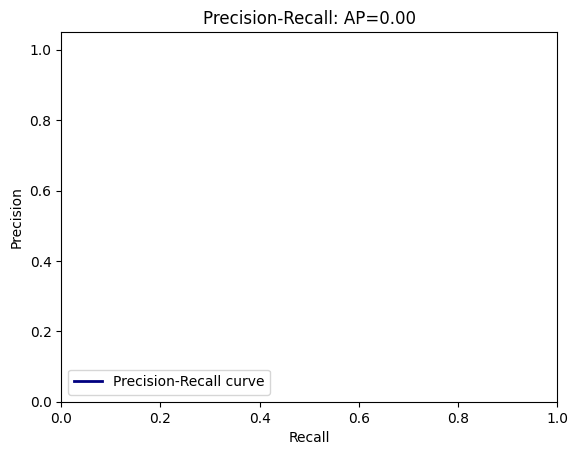

IoU threshold set to: 0.50
TP: 0
FP: 0
FN: 20
Avg. overlap for Pass either side = 0.0000
Precision for Pass either side = 0.0000
Recall for Pass either side = 0.0000
AP for Pass either side = 0.0000


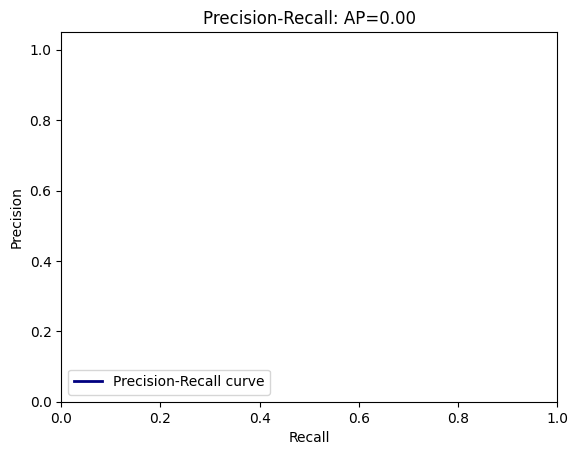

IoU threshold set to: 0.50
TP: 0
FP: 0
FN: 20
Avg. overlap for Obstruction = 0.0000
Precision for Obstruction = 0.0000
Recall for Obstruction = 0.0000
AP for Obstruction = 0.0000


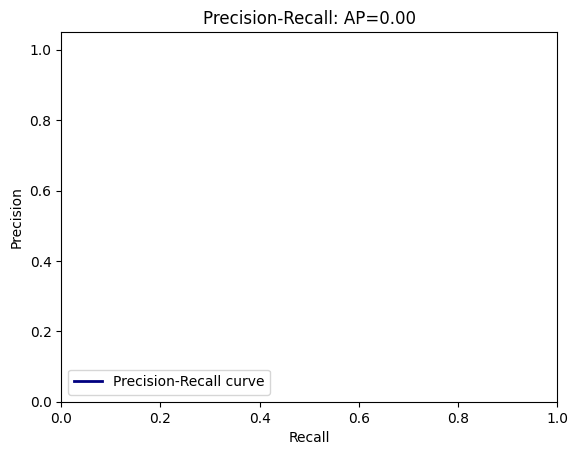

IoU threshold set to: 0.50
TP: 0
FP: 0
FN: 20
Avg. overlap for Roadway diverges = 0.0000
Precision for Roadway diverges = 0.0000
Recall for Roadway diverges = 0.0000
AP for Roadway diverges = 0.0000


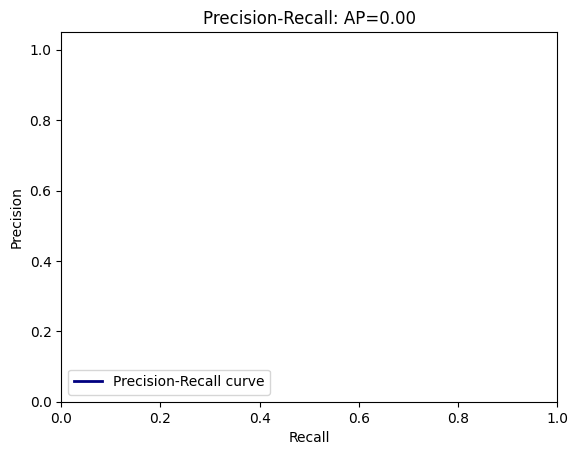

IoU threshold set to: 0.50
TP: 0
FP: 0
FN: 20
Avg. overlap for Bumps = 0.0000
Precision for Bumps = 0.0000
Recall for Bumps = 0.0000
AP for Bumps = 0.0000


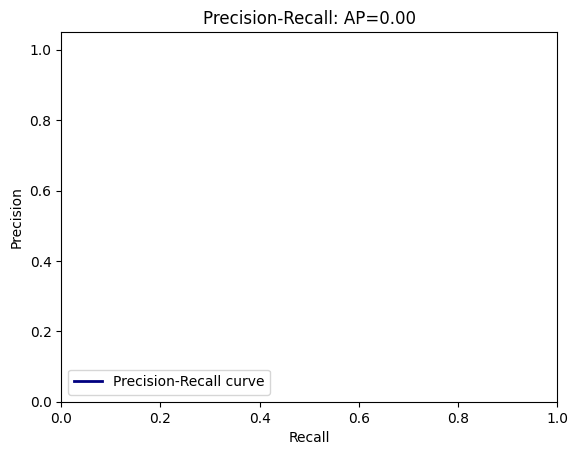

Mean AP = 0.0000
~~~~~~~~
Results:
              class  precision  recall   ap
0       Speed limit        0.0     0.0  0.0
1  Pass either side        0.0     0.0  0.0
2       Obstruction        0.0     0.0  0.0
3  Roadway diverges        0.0     0.0  0.0
4             Bumps        0.0     0.0  0.0


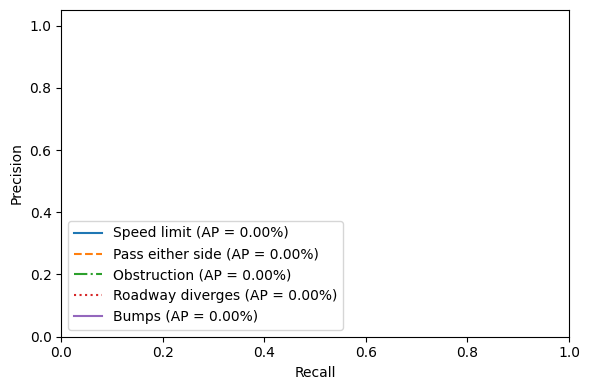

----- Small detections -----
IoU threshold set to: 0.50
TP: 0
FP: 0
FN: 4
Avg. overlap for Speed limit = 0.0000
Precision for Speed limit = 0.0000
Recall for Speed limit = 0.0000
AP for Speed limit = 0.0000


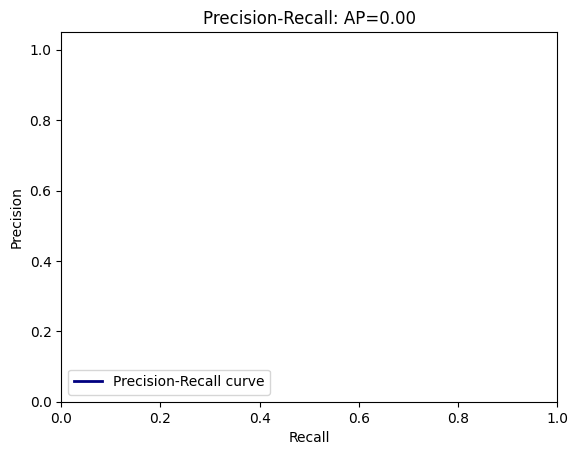

IoU threshold set to: 0.50
IoU threshold set to: 0.50
IoU threshold set to: 0.50
TP: 0
FP: 0
FN: 1
Avg. overlap for Roadway diverges = 0.0000
Precision for Roadway diverges = 0.0000
Recall for Roadway diverges = 0.0000
AP for Roadway diverges = 0.0000


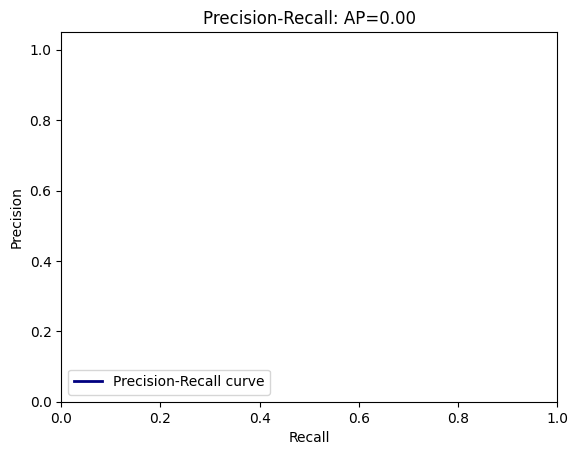

IoU threshold set to: 0.50
Mean AP = 0.0000
~~~~~~~~
Results:
              class  precision  recall   ap
0       Speed limit        0.0     0.0  0.0
1  Roadway diverges        0.0     0.0  0.0


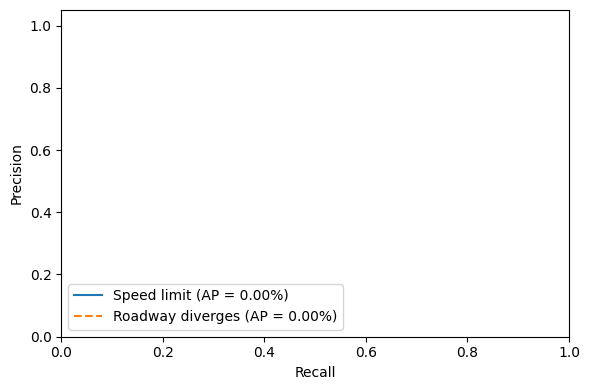

----- Medium detections -----
IoU threshold set to: 0.50
TP: 0
FP: 0
FN: 5
Avg. overlap for Speed limit = 0.0000
Precision for Speed limit = 0.0000
Recall for Speed limit = 0.0000
AP for Speed limit = 0.0000


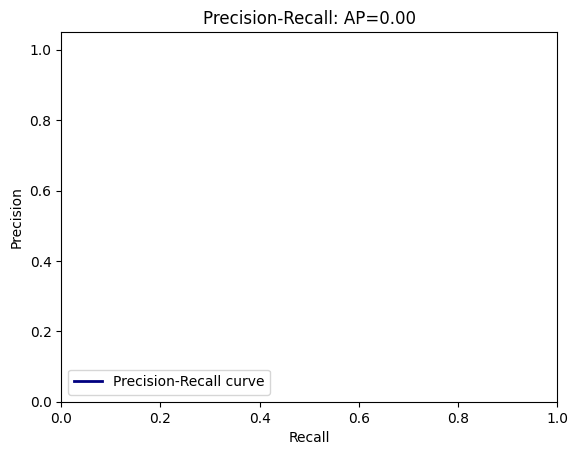

IoU threshold set to: 0.50
IoU threshold set to: 0.50
TP: 0
FP: 0
FN: 2
Avg. overlap for Obstruction = 0.0000
Precision for Obstruction = 0.0000
Recall for Obstruction = 0.0000
AP for Obstruction = 0.0000


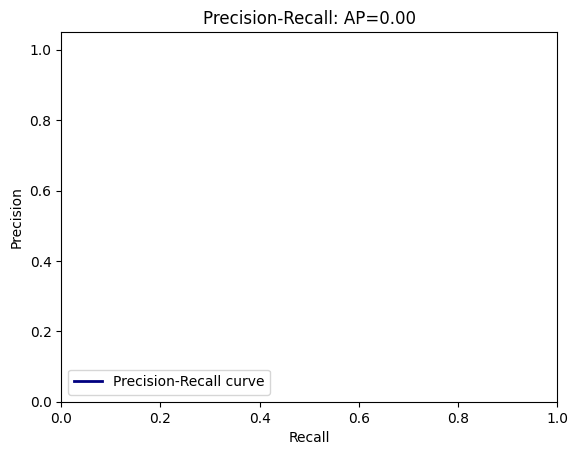

IoU threshold set to: 0.50
TP: 0
FP: 0
FN: 5
Avg. overlap for Roadway diverges = 0.0000
Precision for Roadway diverges = 0.0000
Recall for Roadway diverges = 0.0000
AP for Roadway diverges = 0.0000


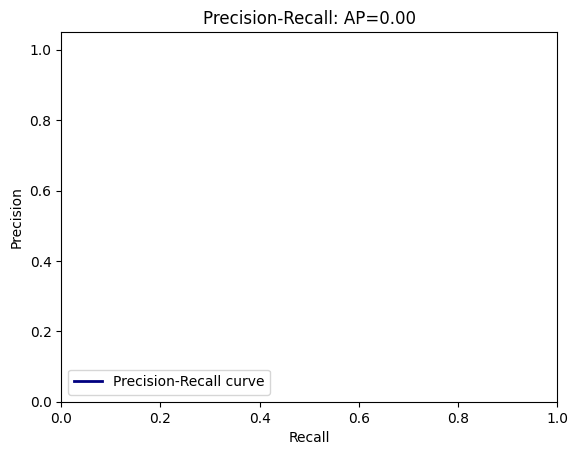

IoU threshold set to: 0.50
TP: 0
FP: 0
FN: 2
Avg. overlap for Bumps = 0.0000
Precision for Bumps = 0.0000
Recall for Bumps = 0.0000
AP for Bumps = 0.0000


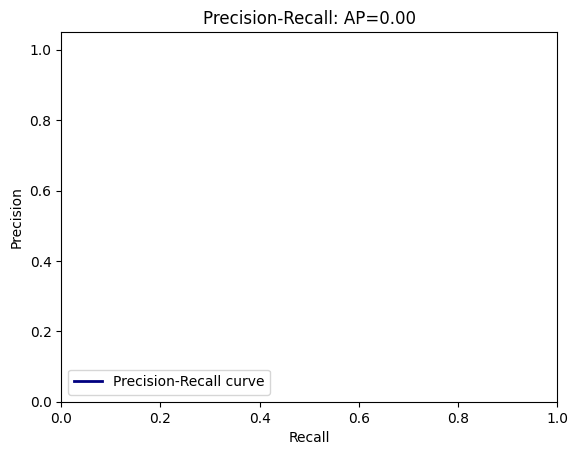

Mean AP = 0.0000
~~~~~~~~
Results:
              class  precision  recall   ap
0       Speed limit        0.0     0.0  0.0
1       Obstruction        0.0     0.0  0.0
2  Roadway diverges        0.0     0.0  0.0
3             Bumps        0.0     0.0  0.0


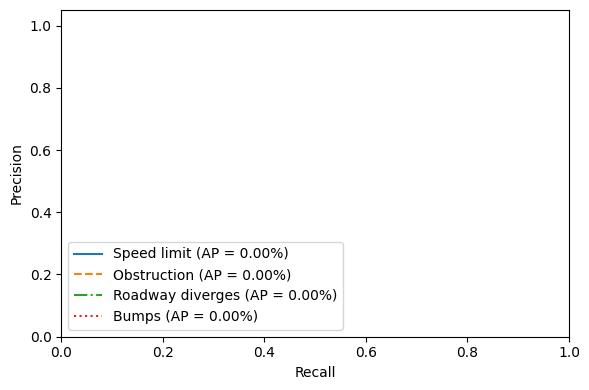

----- Large detections -----
IoU threshold set to: 0.50
TP: 0
FP: 0
FN: 11
Avg. overlap for Speed limit = 0.0000
Precision for Speed limit = 0.0000
Recall for Speed limit = 0.0000
AP for Speed limit = 0.0000


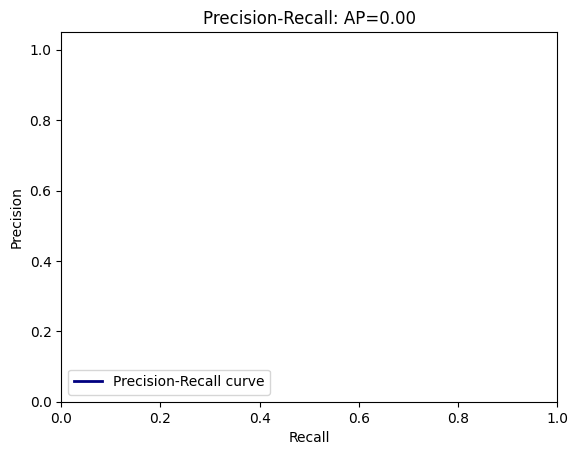

IoU threshold set to: 0.50
TP: 0
FP: 0
FN: 20
Avg. overlap for Pass either side = 0.0000
Precision for Pass either side = 0.0000
Recall for Pass either side = 0.0000
AP for Pass either side = 0.0000


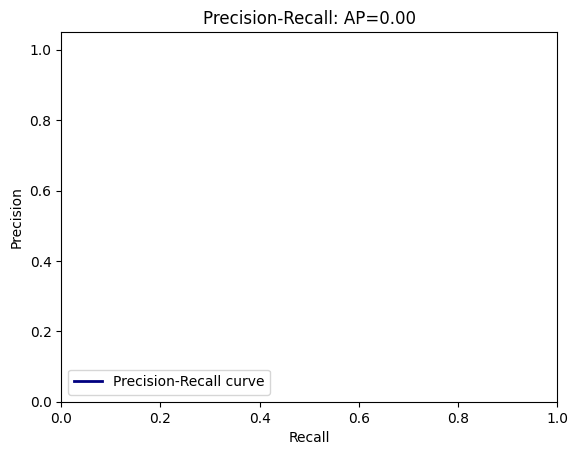

IoU threshold set to: 0.50
TP: 0
FP: 0
FN: 18
Avg. overlap for Obstruction = 0.0000
Precision for Obstruction = 0.0000
Recall for Obstruction = 0.0000
AP for Obstruction = 0.0000


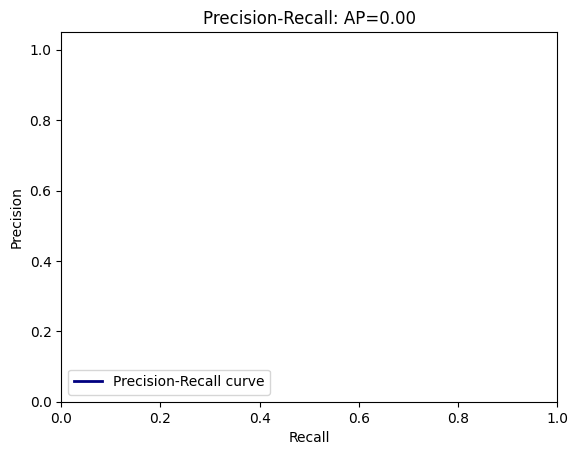

IoU threshold set to: 0.50
TP: 0
FP: 0
FN: 14
Avg. overlap for Roadway diverges = 0.0000
Precision for Roadway diverges = 0.0000
Recall for Roadway diverges = 0.0000
AP for Roadway diverges = 0.0000


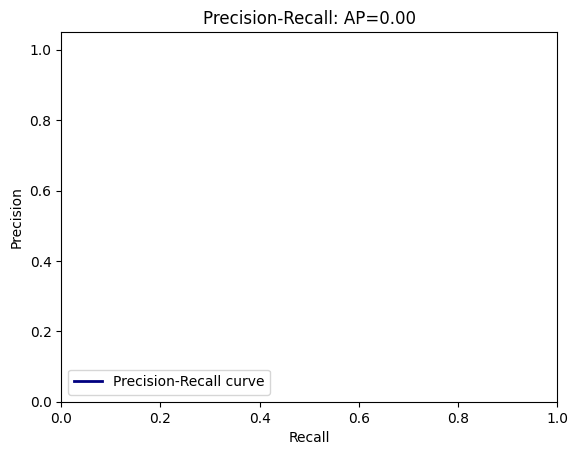

IoU threshold set to: 0.50
TP: 0
FP: 0
FN: 17
Avg. overlap for Bumps = 0.0000
Precision for Bumps = 0.0000
Recall for Bumps = 0.0000
AP for Bumps = 0.0000


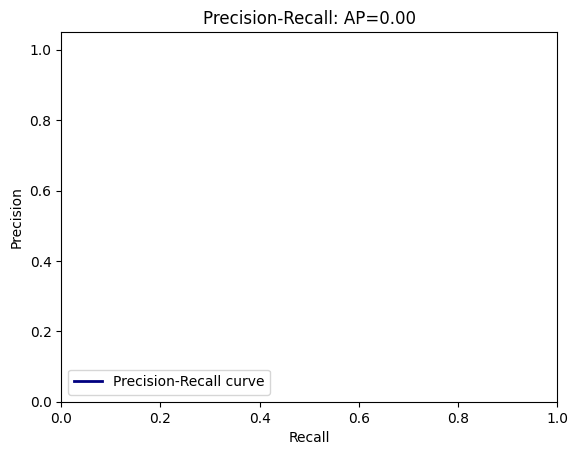

Mean AP = 0.0000
~~~~~~~~
Results:
              class  precision  recall   ap
0       Speed limit        0.0     0.0  0.0
1  Pass either side        0.0     0.0  0.0
2       Obstruction        0.0     0.0  0.0
3  Roadway diverges        0.0     0.0  0.0
4             Bumps        0.0     0.0  0.0


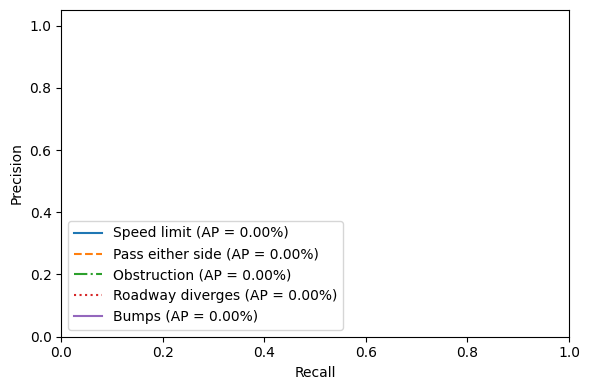

0.0

<Figure size 640x480 with 0 Axes>

In [228]:
compute_mean_average_precision(detections)
print("----- Small detections -----")
compute_mean_average_precision(detections_small)
print("----- Medium detections -----")
compute_mean_average_precision(detections_medium)
print("----- Large detections -----")
compute_mean_average_precision(detections_large)

## Eval Microsoft COCO 2016

IoU threshold set to: 0.50
TP: 0
FP: 0
FN: 20
Avg. overlap for Speed limit = 0.0000
Precision for Speed limit = 0.0000
Recall for Speed limit = 0.0000
AP for Speed limit and IoU threshold 0.50 = 0.0000


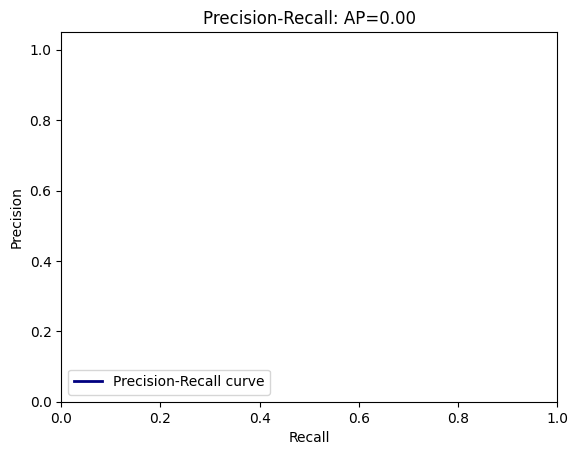

IoU threshold set to: 0.55
TP: 0
FP: 0
FN: 20
Avg. overlap for Speed limit = 0.0000
Precision for Speed limit = 0.0000
Recall for Speed limit = 0.0000
AP for Speed limit and IoU threshold 0.55 = 0.0000


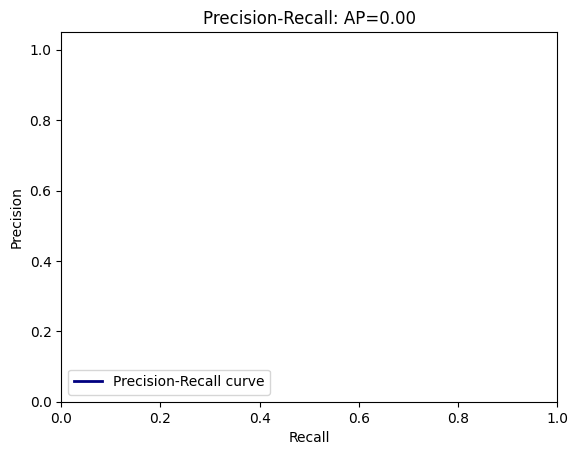

IoU threshold set to: 0.60
TP: 0
FP: 0
FN: 20
Avg. overlap for Speed limit = 0.0000
Precision for Speed limit = 0.0000
Recall for Speed limit = 0.0000
AP for Speed limit and IoU threshold 0.60 = 0.0000


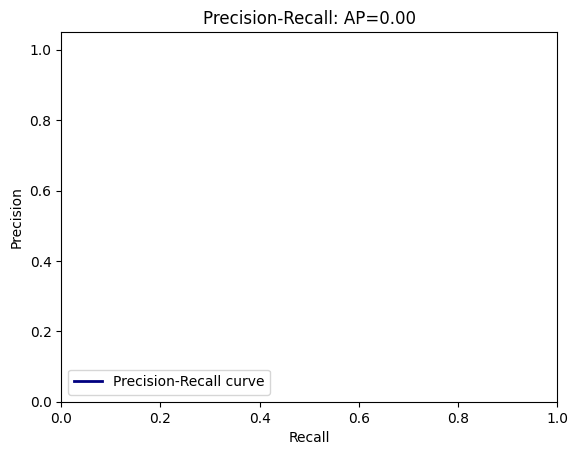

IoU threshold set to: 0.65
TP: 0
FP: 0
FN: 20
Avg. overlap for Speed limit = 0.0000
Precision for Speed limit = 0.0000
Recall for Speed limit = 0.0000
AP for Speed limit and IoU threshold 0.65 = 0.0000


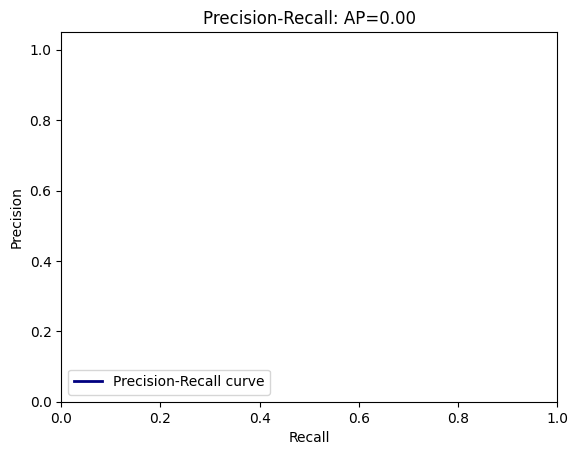

IoU threshold set to: 0.70
TP: 0
FP: 0
FN: 20
Avg. overlap for Speed limit = 0.0000
Precision for Speed limit = 0.0000
Recall for Speed limit = 0.0000
AP for Speed limit and IoU threshold 0.70 = 0.0000


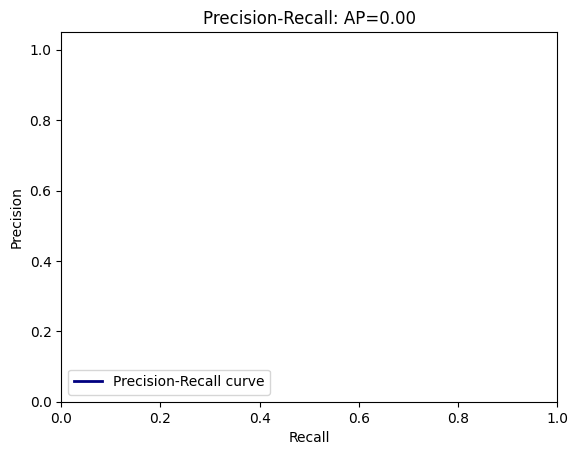

IoU threshold set to: 0.75
TP: 0
FP: 0
FN: 20
Avg. overlap for Speed limit = 0.0000
Precision for Speed limit = 0.0000
Recall for Speed limit = 0.0000
AP for Speed limit and IoU threshold 0.75 = 0.0000


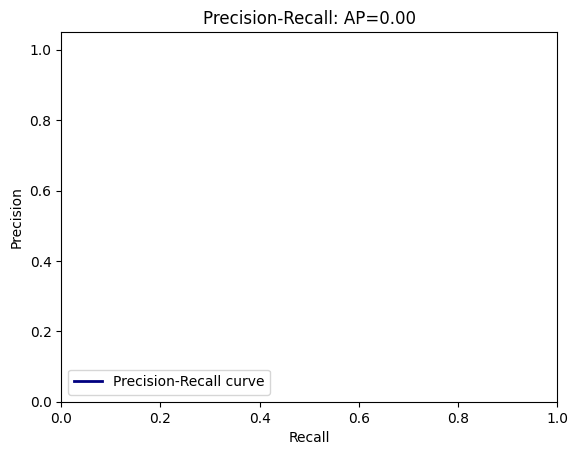

IoU threshold set to: 0.80
TP: 0
FP: 0
FN: 20
Avg. overlap for Speed limit = 0.0000
Precision for Speed limit = 0.0000
Recall for Speed limit = 0.0000
AP for Speed limit and IoU threshold 0.80 = 0.0000


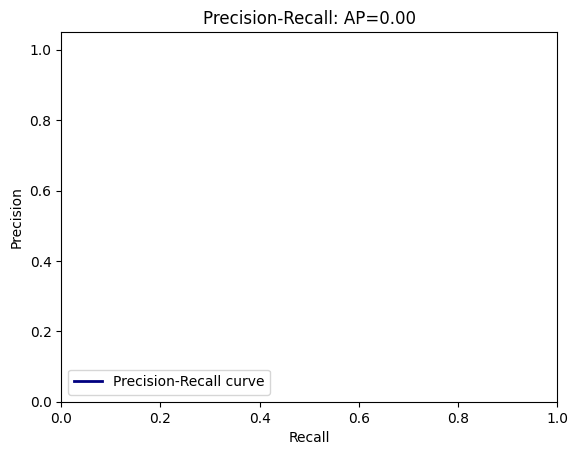

IoU threshold set to: 0.85
TP: 0
FP: 0
FN: 20
Avg. overlap for Speed limit = 0.0000
Precision for Speed limit = 0.0000
Recall for Speed limit = 0.0000
AP for Speed limit and IoU threshold 0.85 = 0.0000


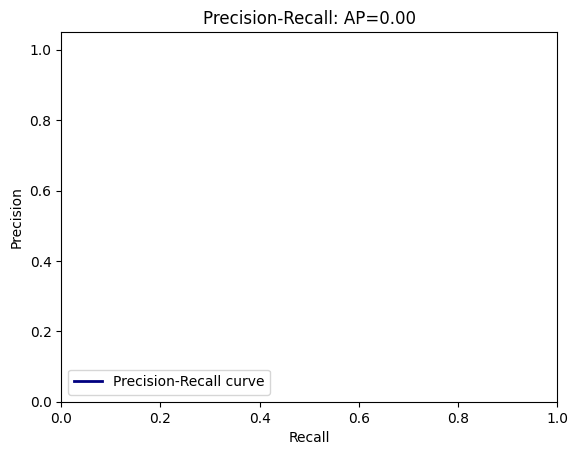

IoU threshold set to: 0.90
TP: 0
FP: 0
FN: 20
Avg. overlap for Speed limit = 0.0000
Precision for Speed limit = 0.0000
Recall for Speed limit = 0.0000
AP for Speed limit and IoU threshold 0.90 = 0.0000


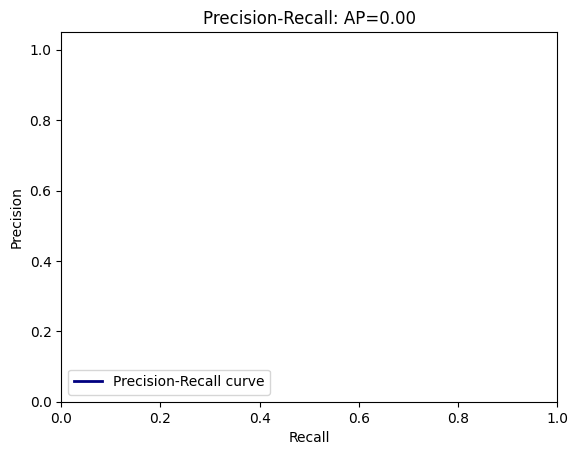

IoU threshold set to: 0.95
TP: 0
FP: 0
FN: 20
Avg. overlap for Speed limit = 0.0000
Precision for Speed limit = 0.0000
Recall for Speed limit = 0.0000
AP for Speed limit and IoU threshold 0.95 = 0.0000


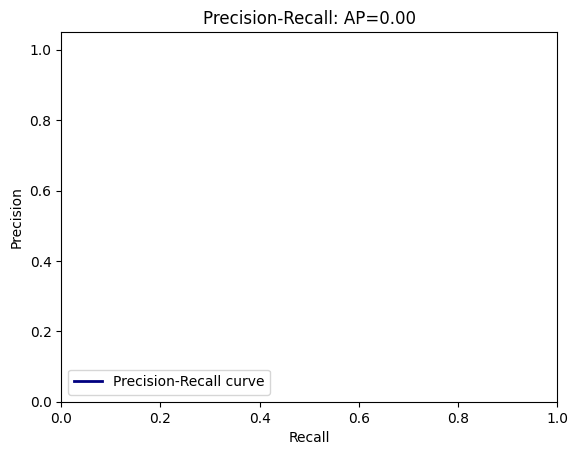

Mean AP for Speed limit = 0.0000
IoU threshold set to: 0.50
TP: 0
FP: 0
FN: 20
Avg. overlap for Pass either side = 0.0000
Precision for Pass either side = 0.0000
Recall for Pass either side = 0.0000
AP for Pass either side and IoU threshold 0.50 = 0.0000


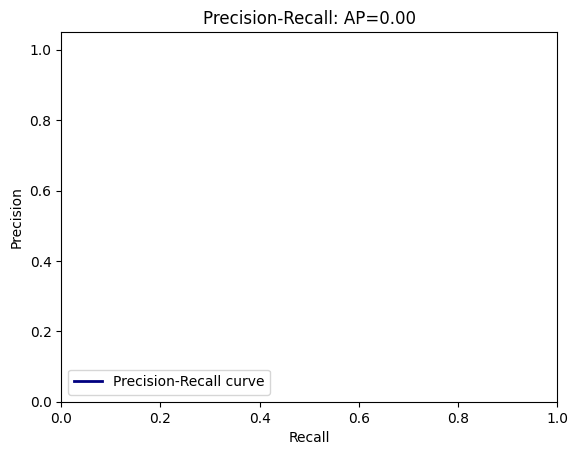

IoU threshold set to: 0.55
TP: 0
FP: 0
FN: 20
Avg. overlap for Pass either side = 0.0000
Precision for Pass either side = 0.0000
Recall for Pass either side = 0.0000
AP for Pass either side and IoU threshold 0.55 = 0.0000


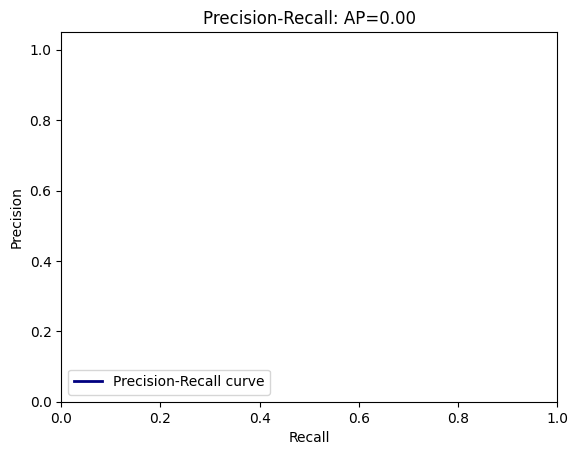

IoU threshold set to: 0.60
TP: 0
FP: 0
FN: 20
Avg. overlap for Pass either side = 0.0000
Precision for Pass either side = 0.0000
Recall for Pass either side = 0.0000
AP for Pass either side and IoU threshold 0.60 = 0.0000


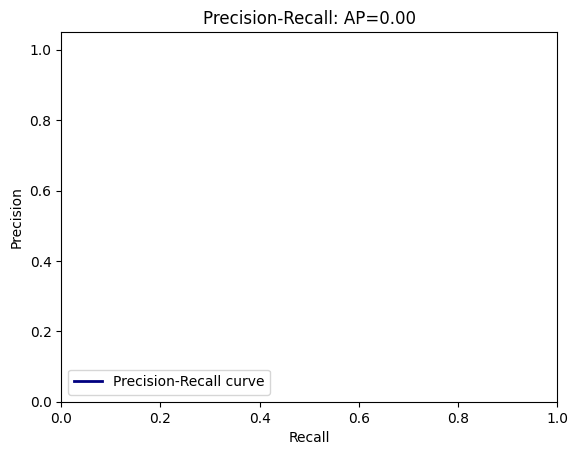

IoU threshold set to: 0.65
TP: 0
FP: 0
FN: 20
Avg. overlap for Pass either side = 0.0000
Precision for Pass either side = 0.0000
Recall for Pass either side = 0.0000
AP for Pass either side and IoU threshold 0.65 = 0.0000


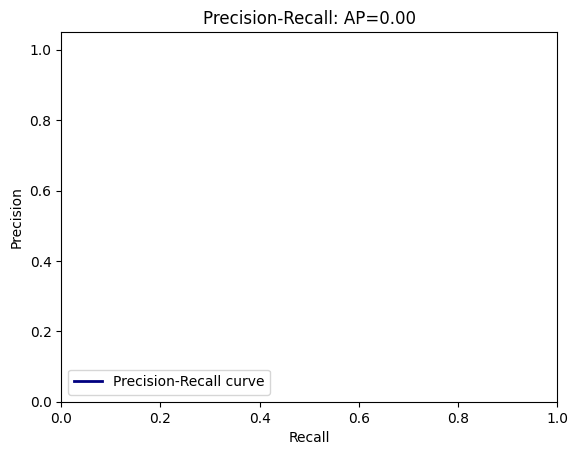

IoU threshold set to: 0.70
TP: 0
FP: 0
FN: 20
Avg. overlap for Pass either side = 0.0000
Precision for Pass either side = 0.0000
Recall for Pass either side = 0.0000
AP for Pass either side and IoU threshold 0.70 = 0.0000


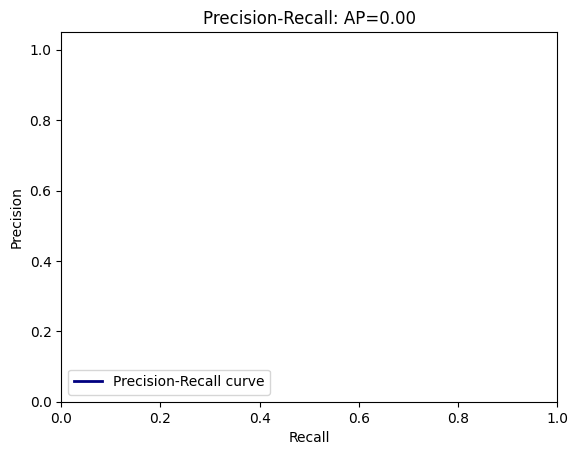

IoU threshold set to: 0.75
TP: 0
FP: 0
FN: 20
Avg. overlap for Pass either side = 0.0000
Precision for Pass either side = 0.0000
Recall for Pass either side = 0.0000
AP for Pass either side and IoU threshold 0.75 = 0.0000


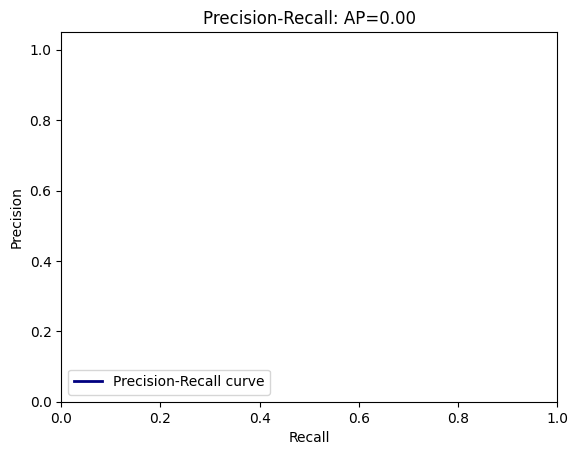

IoU threshold set to: 0.80
TP: 0
FP: 0
FN: 20
Avg. overlap for Pass either side = 0.0000
Precision for Pass either side = 0.0000
Recall for Pass either side = 0.0000
AP for Pass either side and IoU threshold 0.80 = 0.0000


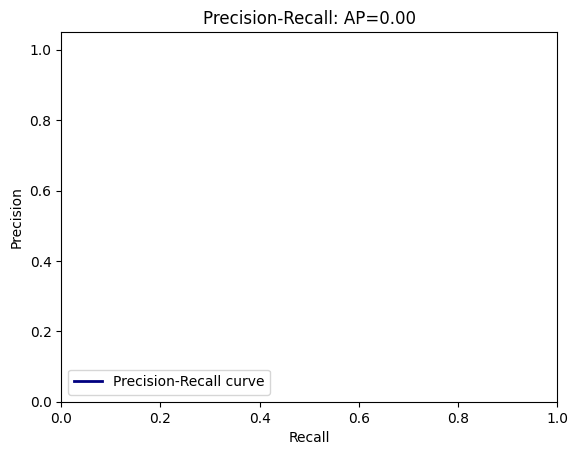

IoU threshold set to: 0.85
TP: 0
FP: 0
FN: 20
Avg. overlap for Pass either side = 0.0000
Precision for Pass either side = 0.0000
Recall for Pass either side = 0.0000
AP for Pass either side and IoU threshold 0.85 = 0.0000


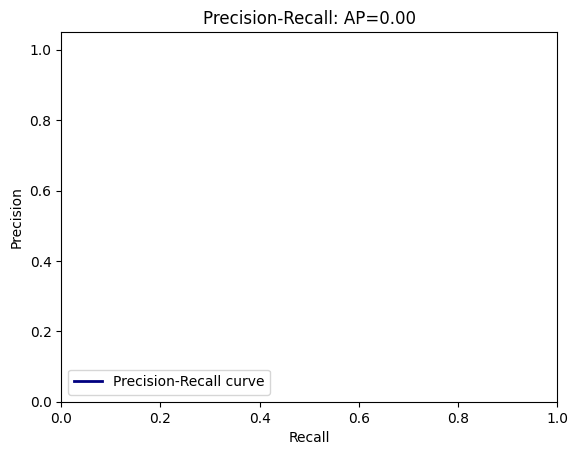

IoU threshold set to: 0.90
TP: 0
FP: 0
FN: 20
Avg. overlap for Pass either side = 0.0000
Precision for Pass either side = 0.0000
Recall for Pass either side = 0.0000
AP for Pass either side and IoU threshold 0.90 = 0.0000


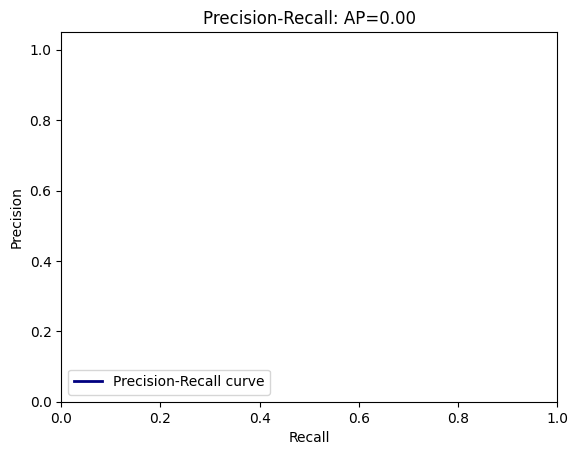

IoU threshold set to: 0.95
TP: 0
FP: 0
FN: 20
Avg. overlap for Pass either side = 0.0000
Precision for Pass either side = 0.0000
Recall for Pass either side = 0.0000
AP for Pass either side and IoU threshold 0.95 = 0.0000


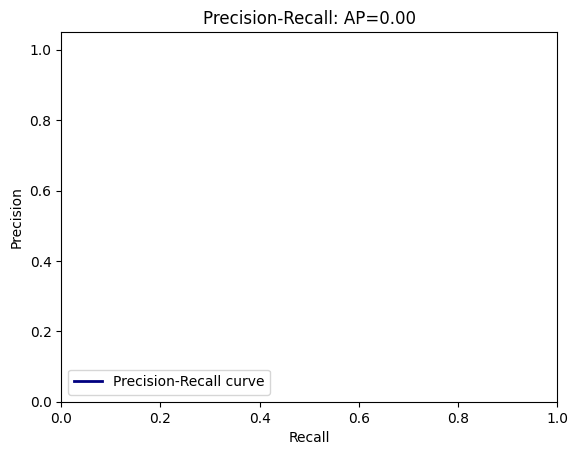

Mean AP for Pass either side = 0.0000
IoU threshold set to: 0.50
TP: 0
FP: 0
FN: 20
Avg. overlap for Obstruction = 0.0000
Precision for Obstruction = 0.0000
Recall for Obstruction = 0.0000
AP for Obstruction and IoU threshold 0.50 = 0.0000


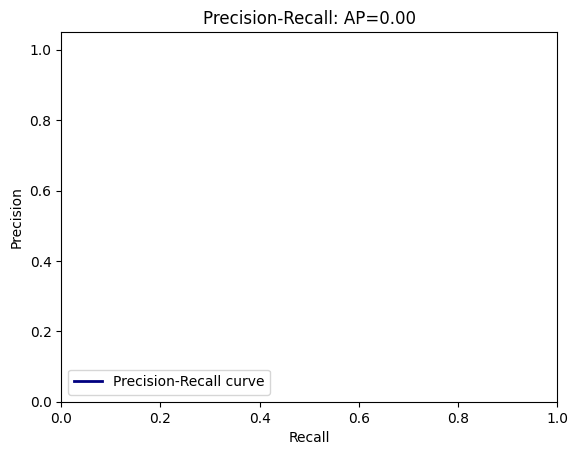

IoU threshold set to: 0.55
TP: 0
FP: 0
FN: 20
Avg. overlap for Obstruction = 0.0000
Precision for Obstruction = 0.0000
Recall for Obstruction = 0.0000
AP for Obstruction and IoU threshold 0.55 = 0.0000


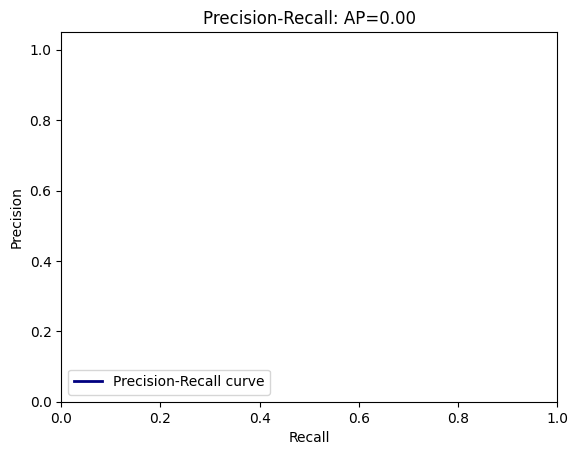

IoU threshold set to: 0.60
TP: 0
FP: 0
FN: 20
Avg. overlap for Obstruction = 0.0000
Precision for Obstruction = 0.0000
Recall for Obstruction = 0.0000
AP for Obstruction and IoU threshold 0.60 = 0.0000


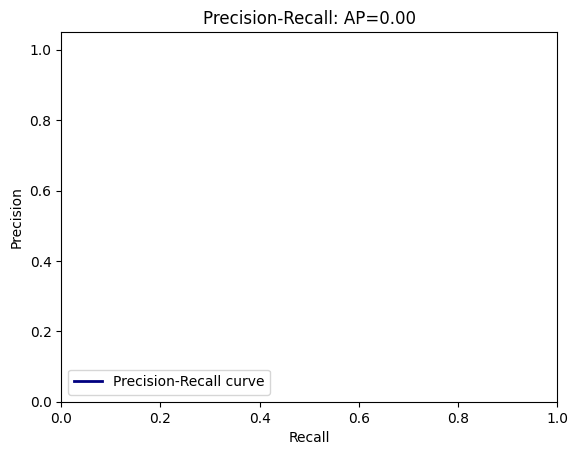

IoU threshold set to: 0.65
TP: 0
FP: 0
FN: 20
Avg. overlap for Obstruction = 0.0000
Precision for Obstruction = 0.0000
Recall for Obstruction = 0.0000
AP for Obstruction and IoU threshold 0.65 = 0.0000


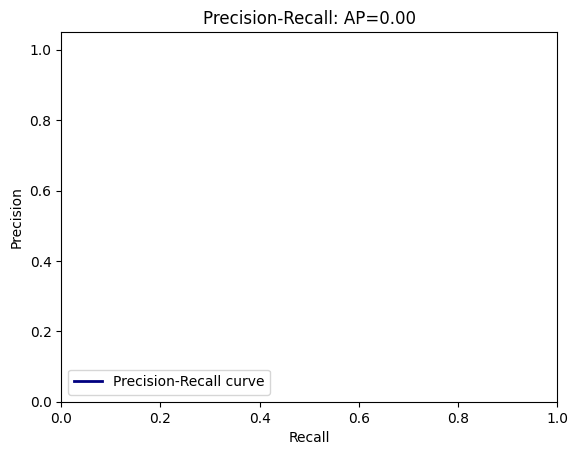

IoU threshold set to: 0.70
TP: 0
FP: 0
FN: 20
Avg. overlap for Obstruction = 0.0000
Precision for Obstruction = 0.0000
Recall for Obstruction = 0.0000
AP for Obstruction and IoU threshold 0.70 = 0.0000


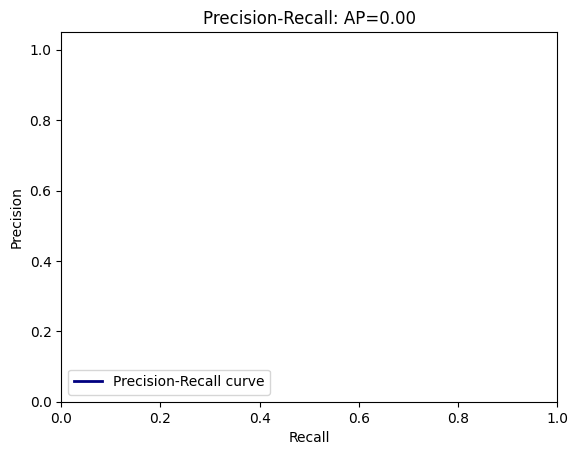

IoU threshold set to: 0.75
TP: 0
FP: 0
FN: 20
Avg. overlap for Obstruction = 0.0000
Precision for Obstruction = 0.0000
Recall for Obstruction = 0.0000
AP for Obstruction and IoU threshold 0.75 = 0.0000


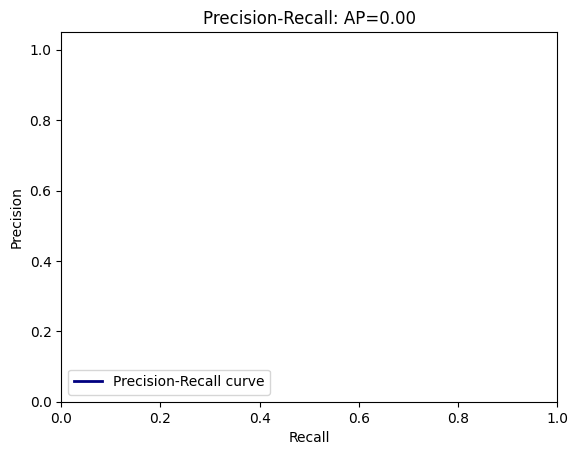

IoU threshold set to: 0.80
TP: 0
FP: 0
FN: 20
Avg. overlap for Obstruction = 0.0000
Precision for Obstruction = 0.0000
Recall for Obstruction = 0.0000
AP for Obstruction and IoU threshold 0.80 = 0.0000


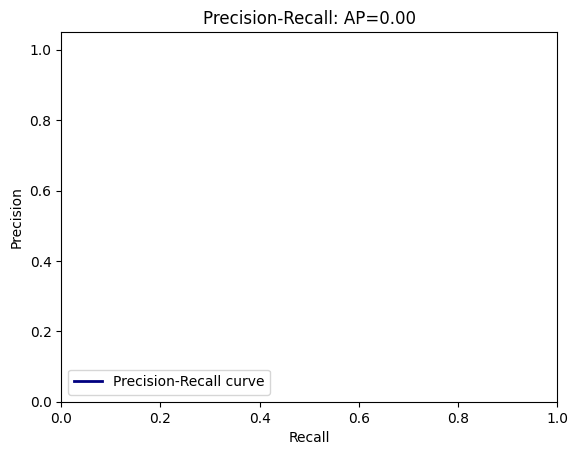

IoU threshold set to: 0.85
TP: 0
FP: 0
FN: 20
Avg. overlap for Obstruction = 0.0000
Precision for Obstruction = 0.0000
Recall for Obstruction = 0.0000
AP for Obstruction and IoU threshold 0.85 = 0.0000


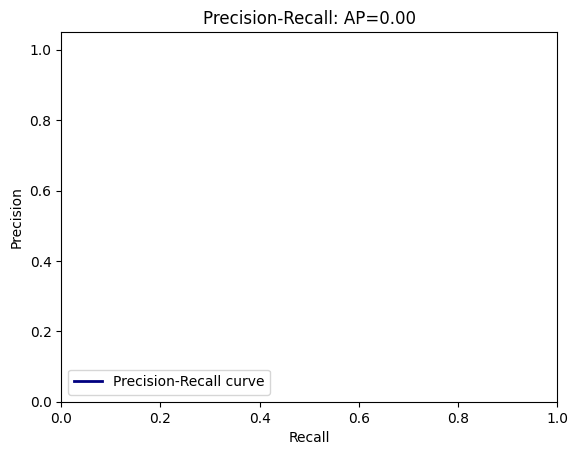

IoU threshold set to: 0.90
TP: 0
FP: 0
FN: 20
Avg. overlap for Obstruction = 0.0000
Precision for Obstruction = 0.0000
Recall for Obstruction = 0.0000
AP for Obstruction and IoU threshold 0.90 = 0.0000


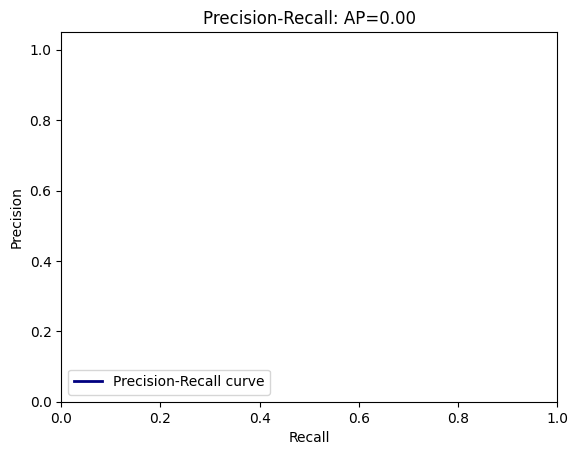

IoU threshold set to: 0.95
TP: 0
FP: 0
FN: 20
Avg. overlap for Obstruction = 0.0000
Precision for Obstruction = 0.0000
Recall for Obstruction = 0.0000
AP for Obstruction and IoU threshold 0.95 = 0.0000


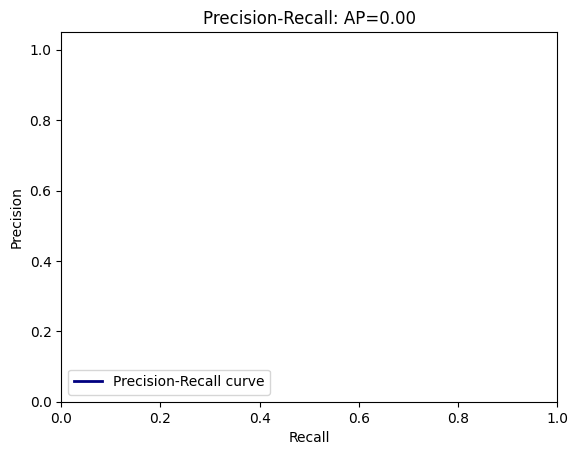

Mean AP for Obstruction = 0.0000
IoU threshold set to: 0.50
TP: 0
FP: 0
FN: 20
Avg. overlap for Roadway diverges = 0.0000
Precision for Roadway diverges = 0.0000
Recall for Roadway diverges = 0.0000
AP for Roadway diverges and IoU threshold 0.50 = 0.0000


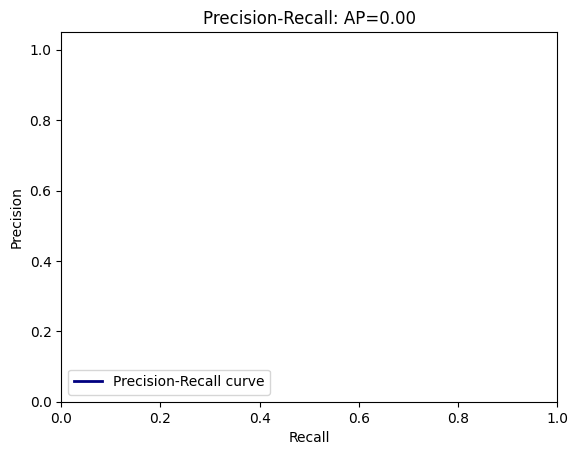

IoU threshold set to: 0.55
TP: 0
FP: 0
FN: 20
Avg. overlap for Roadway diverges = 0.0000
Precision for Roadway diverges = 0.0000
Recall for Roadway diverges = 0.0000
AP for Roadway diverges and IoU threshold 0.55 = 0.0000


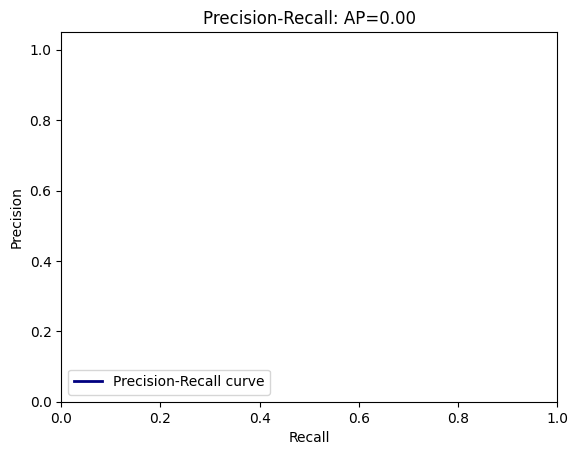

IoU threshold set to: 0.60
TP: 0
FP: 0
FN: 20
Avg. overlap for Roadway diverges = 0.0000
Precision for Roadway diverges = 0.0000
Recall for Roadway diverges = 0.0000
AP for Roadway diverges and IoU threshold 0.60 = 0.0000


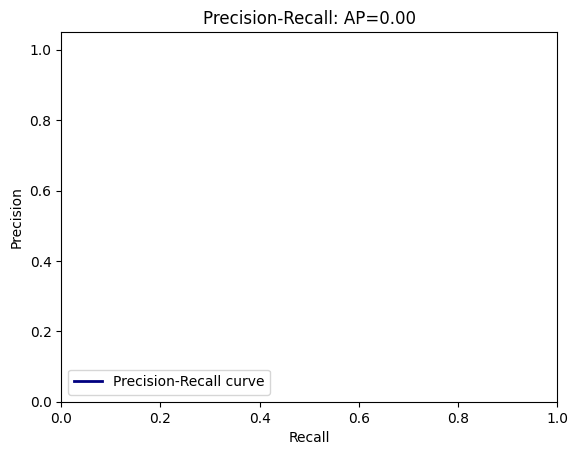

IoU threshold set to: 0.65
TP: 0
FP: 0
FN: 20
Avg. overlap for Roadway diverges = 0.0000
Precision for Roadway diverges = 0.0000
Recall for Roadway diverges = 0.0000
AP for Roadway diverges and IoU threshold 0.65 = 0.0000


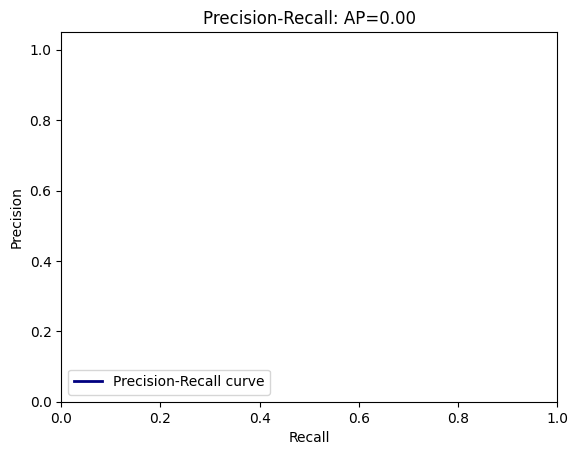

IoU threshold set to: 0.70
TP: 0
FP: 0
FN: 20
Avg. overlap for Roadway diverges = 0.0000
Precision for Roadway diverges = 0.0000
Recall for Roadway diverges = 0.0000
AP for Roadway diverges and IoU threshold 0.70 = 0.0000


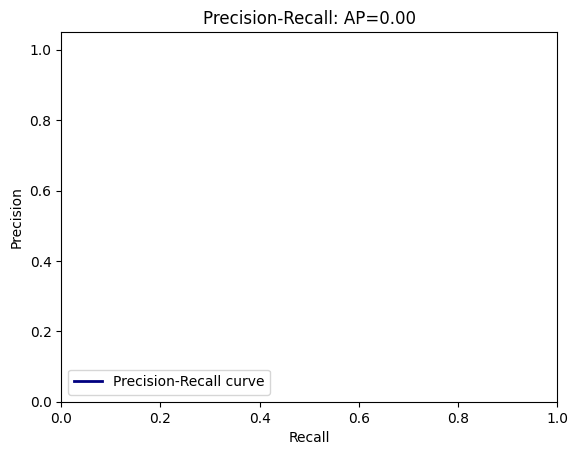

IoU threshold set to: 0.75
TP: 0
FP: 0
FN: 20
Avg. overlap for Roadway diverges = 0.0000
Precision for Roadway diverges = 0.0000
Recall for Roadway diverges = 0.0000
AP for Roadway diverges and IoU threshold 0.75 = 0.0000


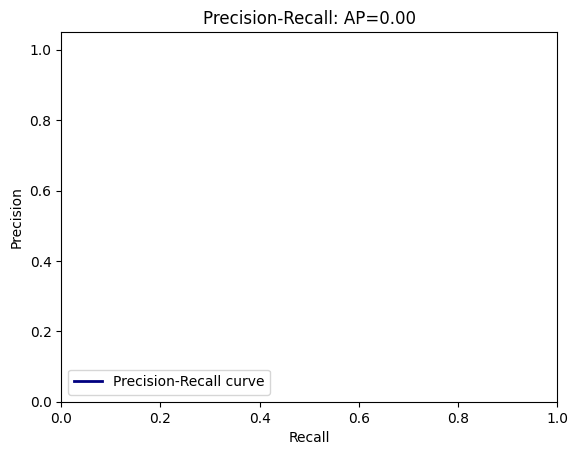

IoU threshold set to: 0.80
TP: 0
FP: 0
FN: 20
Avg. overlap for Roadway diverges = 0.0000
Precision for Roadway diverges = 0.0000
Recall for Roadway diverges = 0.0000
AP for Roadway diverges and IoU threshold 0.80 = 0.0000


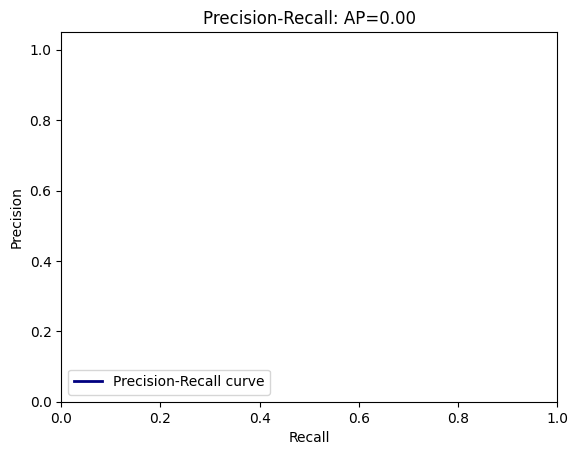

IoU threshold set to: 0.85
TP: 0
FP: 0
FN: 20
Avg. overlap for Roadway diverges = 0.0000
Precision for Roadway diverges = 0.0000
Recall for Roadway diverges = 0.0000
AP for Roadway diverges and IoU threshold 0.85 = 0.0000


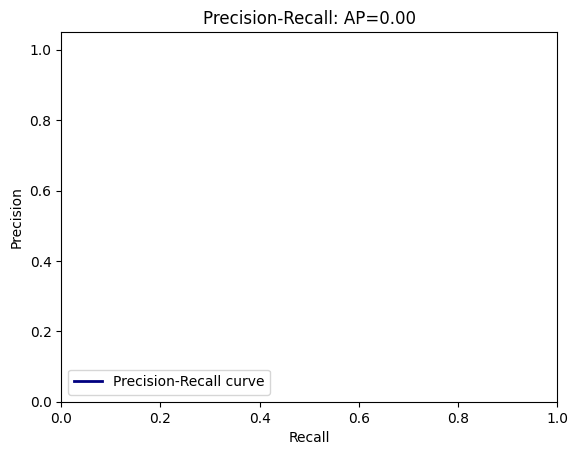

IoU threshold set to: 0.90
TP: 0
FP: 0
FN: 20
Avg. overlap for Roadway diverges = 0.0000
Precision for Roadway diverges = 0.0000
Recall for Roadway diverges = 0.0000
AP for Roadway diverges and IoU threshold 0.90 = 0.0000


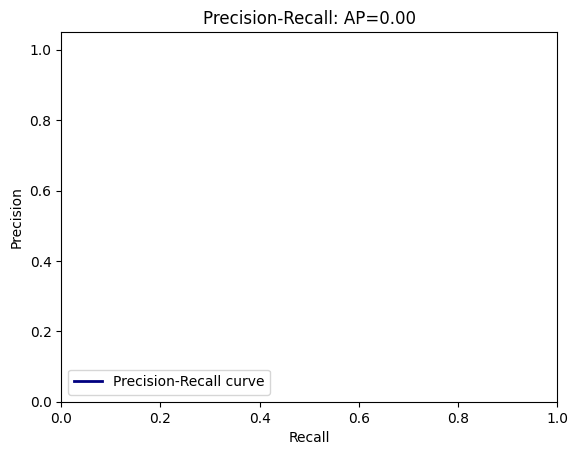

IoU threshold set to: 0.95
TP: 0
FP: 0
FN: 20
Avg. overlap for Roadway diverges = 0.0000
Precision for Roadway diverges = 0.0000
Recall for Roadway diverges = 0.0000
AP for Roadway diverges and IoU threshold 0.95 = 0.0000


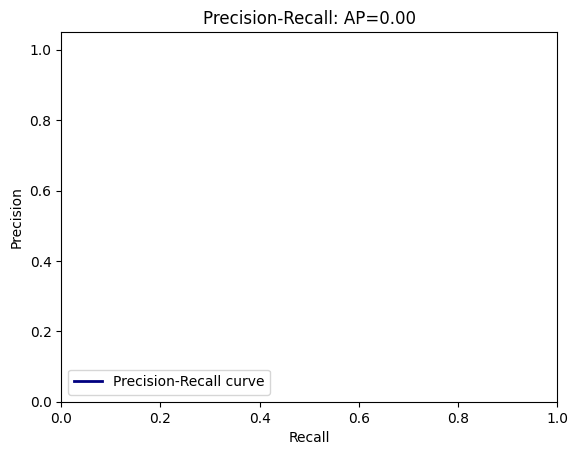

Mean AP for Roadway diverges = 0.0000
IoU threshold set to: 0.50
TP: 0
FP: 0
FN: 20
Avg. overlap for Bumps = 0.0000
Precision for Bumps = 0.0000
Recall for Bumps = 0.0000
AP for Bumps and IoU threshold 0.50 = 0.0000


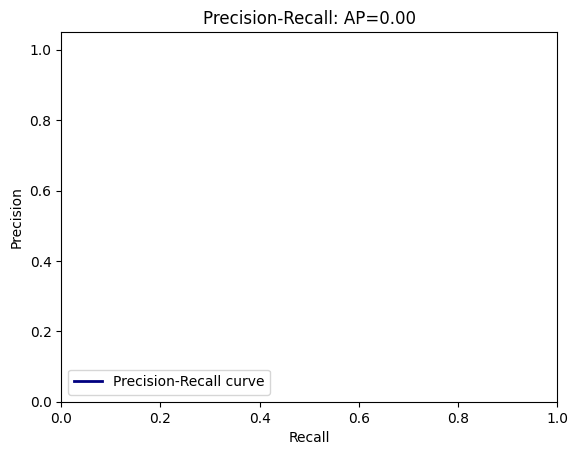

IoU threshold set to: 0.55
TP: 0
FP: 0
FN: 20
Avg. overlap for Bumps = 0.0000
Precision for Bumps = 0.0000
Recall for Bumps = 0.0000
AP for Bumps and IoU threshold 0.55 = 0.0000


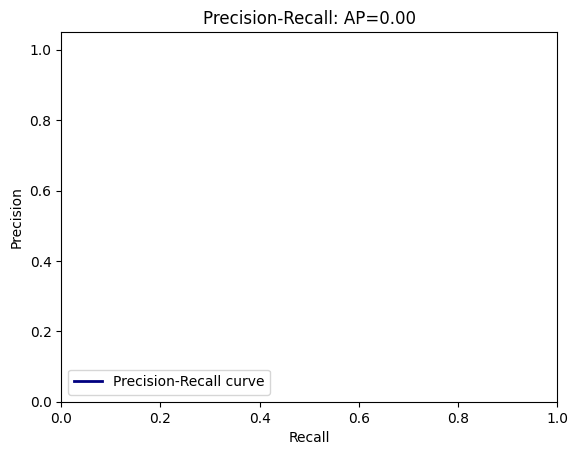

IoU threshold set to: 0.60
TP: 0
FP: 0
FN: 20
Avg. overlap for Bumps = 0.0000
Precision for Bumps = 0.0000
Recall for Bumps = 0.0000
AP for Bumps and IoU threshold 0.60 = 0.0000


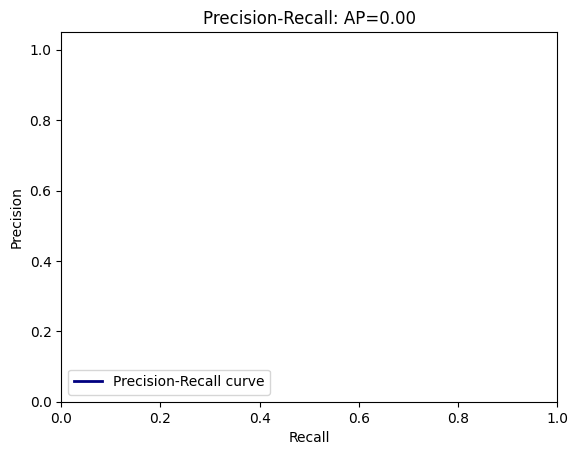

IoU threshold set to: 0.65
TP: 0
FP: 0
FN: 20
Avg. overlap for Bumps = 0.0000
Precision for Bumps = 0.0000
Recall for Bumps = 0.0000
AP for Bumps and IoU threshold 0.65 = 0.0000


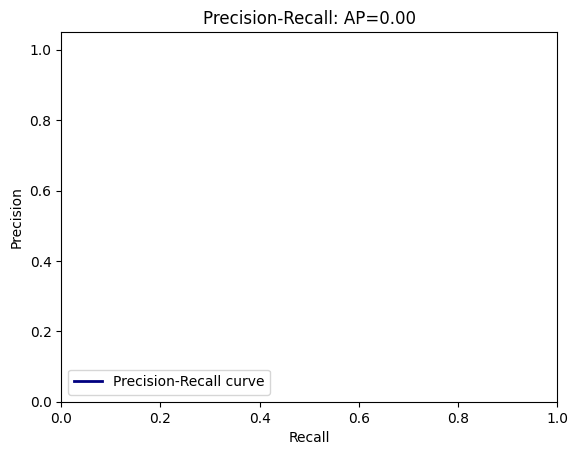

IoU threshold set to: 0.70
TP: 0
FP: 0
FN: 20
Avg. overlap for Bumps = 0.0000
Precision for Bumps = 0.0000
Recall for Bumps = 0.0000
AP for Bumps and IoU threshold 0.70 = 0.0000


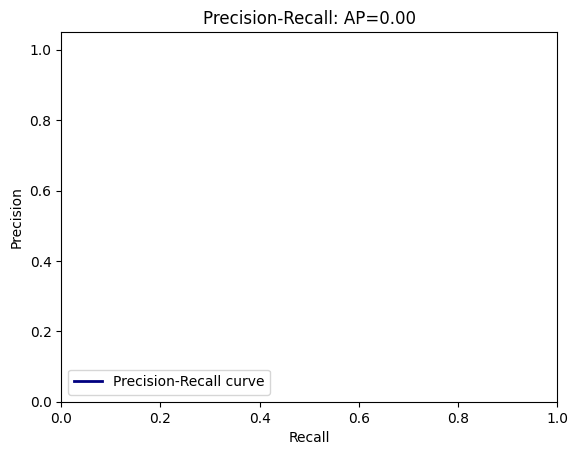

IoU threshold set to: 0.75
TP: 0
FP: 0
FN: 20
Avg. overlap for Bumps = 0.0000
Precision for Bumps = 0.0000
Recall for Bumps = 0.0000
AP for Bumps and IoU threshold 0.75 = 0.0000


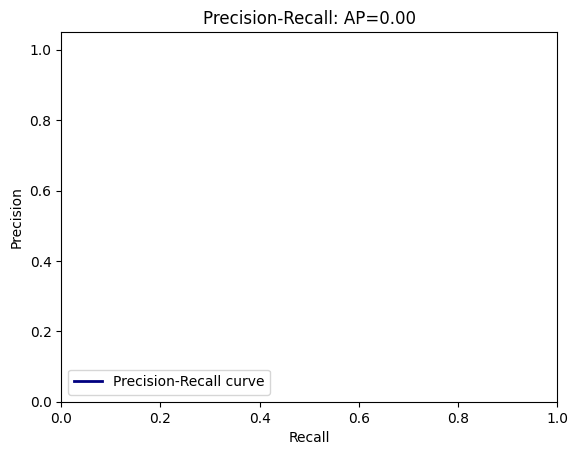

IoU threshold set to: 0.80
TP: 0
FP: 0
FN: 20
Avg. overlap for Bumps = 0.0000
Precision for Bumps = 0.0000
Recall for Bumps = 0.0000
AP for Bumps and IoU threshold 0.80 = 0.0000


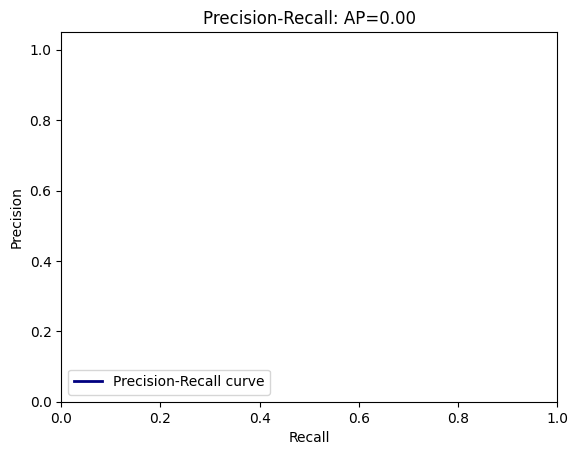

IoU threshold set to: 0.85
TP: 0
FP: 0
FN: 20
Avg. overlap for Bumps = 0.0000
Precision for Bumps = 0.0000
Recall for Bumps = 0.0000
AP for Bumps and IoU threshold 0.85 = 0.0000


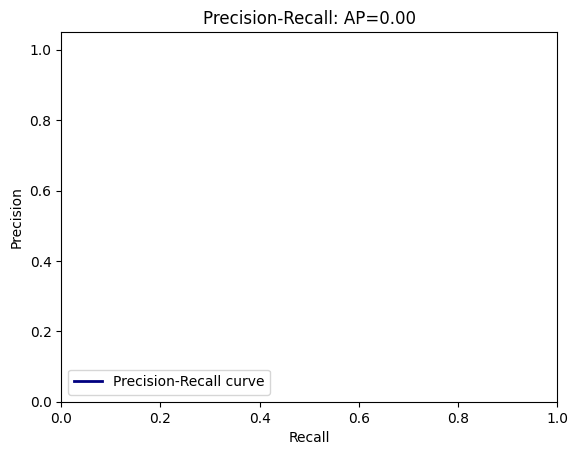

IoU threshold set to: 0.90
TP: 0
FP: 0
FN: 20
Avg. overlap for Bumps = 0.0000
Precision for Bumps = 0.0000
Recall for Bumps = 0.0000
AP for Bumps and IoU threshold 0.90 = 0.0000


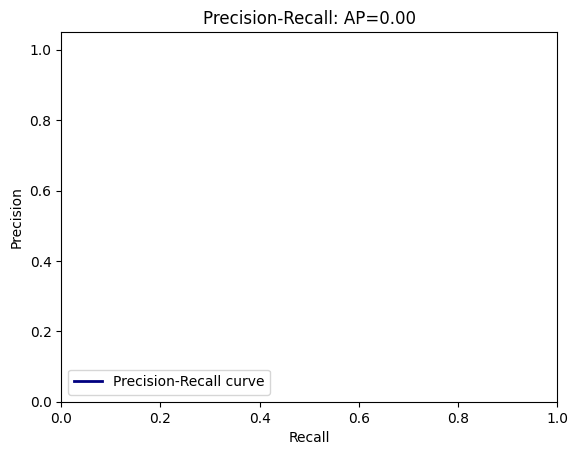

IoU threshold set to: 0.95
TP: 0
FP: 0
FN: 20
Avg. overlap for Bumps = 0.0000
Precision for Bumps = 0.0000
Recall for Bumps = 0.0000
AP for Bumps and IoU threshold 0.95 = 0.0000


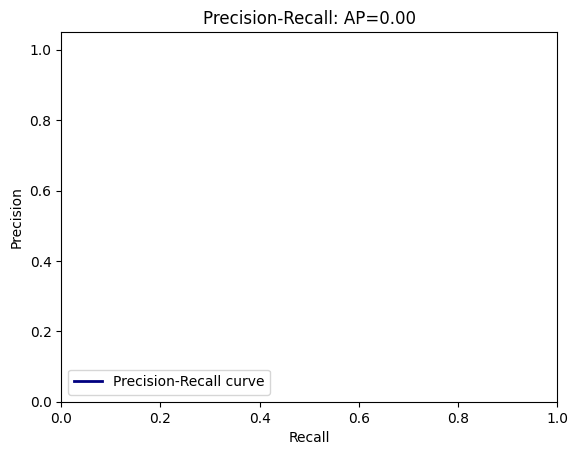

Mean AP for Bumps = 0.0000
COCO-style Mean AP = 0.0000
~~~~~~~~
Results:
0.000
0.000
0.000
0.000
0.000
Final mAP: 0.000


0.0

In [229]:
compute_mean_average_precision_COCO2016(detections)

## Plot detections

In [232]:
sample = get_detection_by_filename(detections, '0_00004_00019-ppm_jpg.rf.56d95ce6322573e857411c476b37f06e.jpg')
sample

{'pred_bboxes': [[[0.0, 0.0, 0.7108811140060425, 0.9997694492340088],
   [0.07837995886802673,
    0.028226643800735474,
    0.59113609790802,
    0.8530864715576172],
   [0.0, 0.0, 0.7108811140060425, 0.9997694492340088],
   [0.03623265027999878,
    0.009220540523529053,
    0.8829835057258606,
    0.9301968812942505],
   [0.07837995886802673,
    0.028226643800735474,
    0.59113609790802,
    0.8530864715576172],
   [0.0, 0.0, 0.7108811140060425, 0.9997694492340088],
   [0.07837995886802673,
    0.028226643800735474,
    0.59113609790802,
    0.8530864715576172],
   [0.0, 0.09654992818832397, 0.9380576610565186, 0.8532766699790955],
   [0.0674142837524414, 0.0, 1.0, 1.0],
   [0.0, 0.008036524057388306, 0.5148969292640686, 0.9908500909805298],
   [0.0, 0.012500077486038208, 1.0, 0.9349007606506348],
   [0.0, 0.23012351989746094, 0.7997674942016602, 0.966109037399292],
   [0.0, 0.008036524057388306, 0.5148969292640686, 0.9908500909805298],
   [0.0674142837524414, 0.0, 1.0, 1.0],
   [

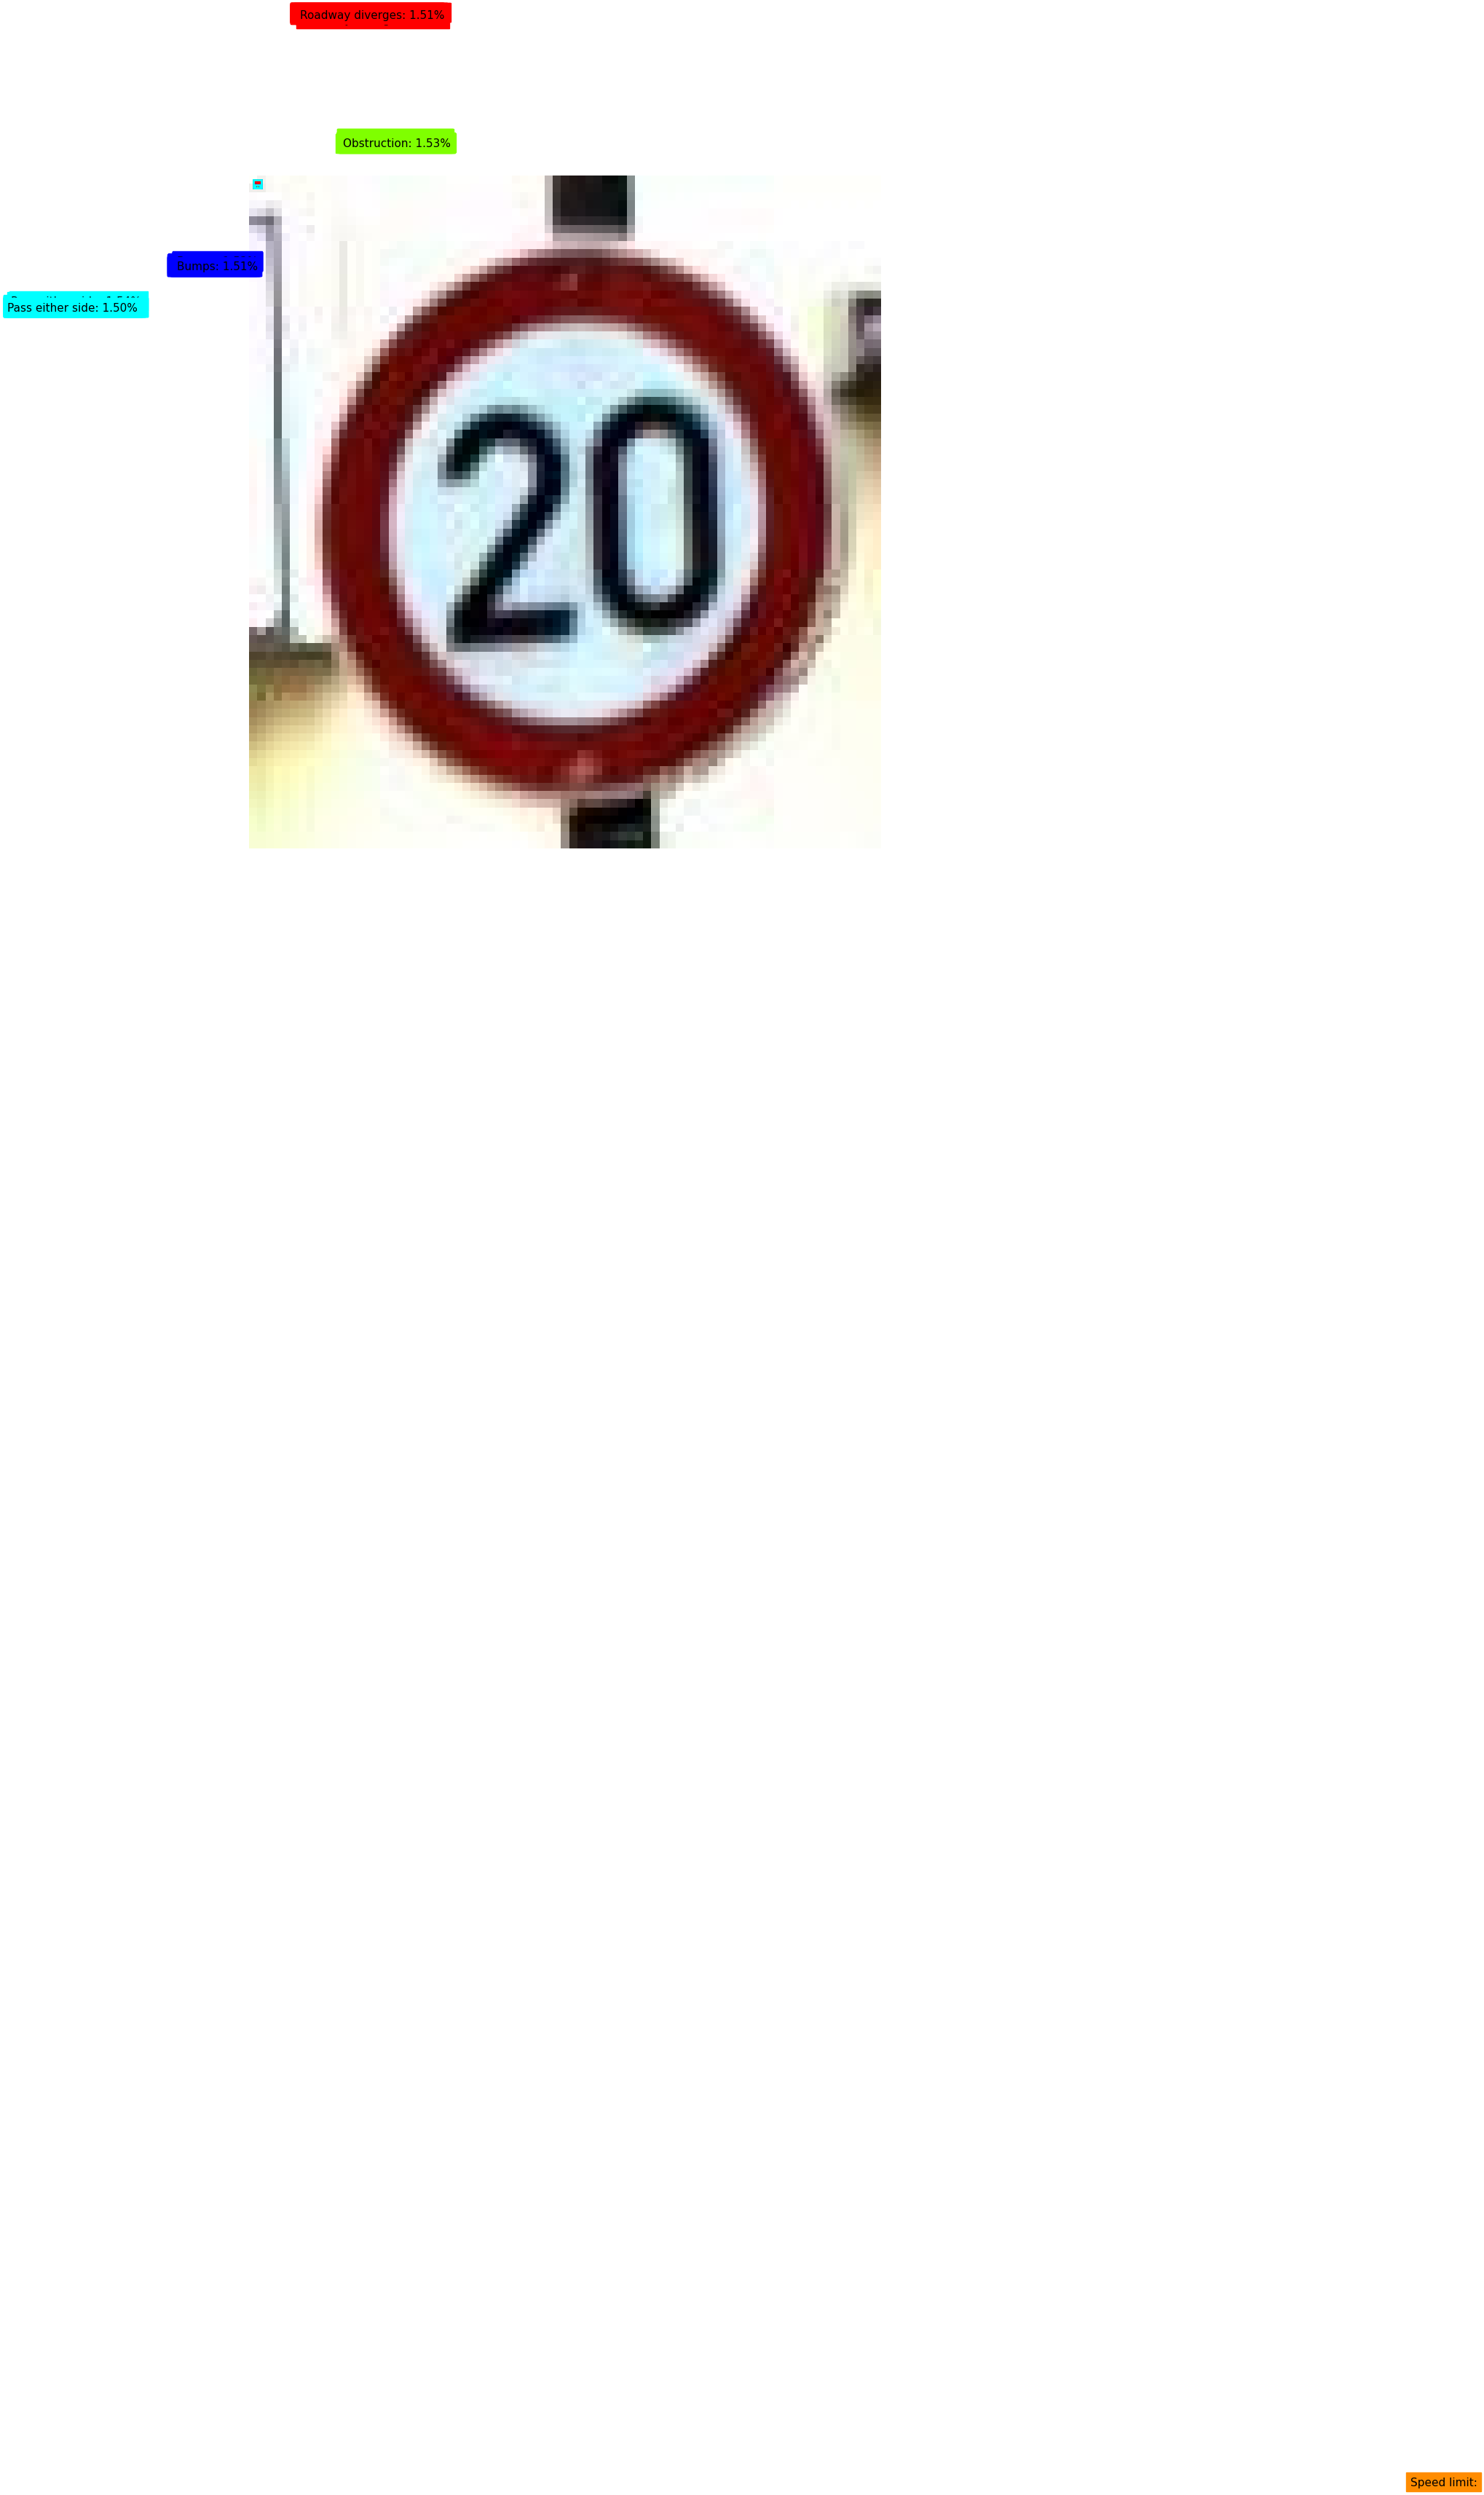

In [242]:
filename = '0_00004_00019-ppm_jpg.rf.56d95ce6322573e857411c476b37f06e.jpg'
plot_dets(sample, filename)